In [1]:
# Libraries

import matplotlib
import numpy
import os
import pandas
import platform
import seaborn
import shutil
import sys
import warnings

In [2]:
# Ensure source path

ROOT = os.getcwd()

while not ROOT.endswith('upolanc-thesis') :
	ROOT = os.path.abspath(os.path.join(ROOT, os.pardir))

	if len(ROOT) < len('upolanc-thesis') :
		if   platform.system() == 'Linux'   : ROOT = '/d/hpc/projects/FRI/up4472/upolanc-thesis'
		elif platform.system() == 'Windows' : ROOT = 'C:\\Developer\\Workspace\\PyCharm\\Projects\\upolanc-thesis'
		else : raise ValueError()

		print(f'Warning : could not find correct directory, using default : {ROOT}')
		print()

		break

if ROOT not in sys.path :
	sys.path.append(ROOT)

os.chdir(ROOT)

In [3]:
# Code

from source.python.data.analysis import analysis_statistics
from source.python.data.feature  import feature_anndata
from source.python.io            import loader
from source.python.io            import writer
from source.python               import runtime

runtime.set_numpy_format()
runtime.set_pandas_format()
runtime.set_plot_theme()

# 1. Setup

In [4]:
# Setup some directory paths

FILTER_ID = 6
SUBFOLDER = 'filter' + str(FILTER_ID)

CWD = ROOT
OUT = os.path.join(CWD, 'output')
RES = os.path.join(CWD, 'resources')

OUT_DATA  = os.path.join(OUT,      'nbp02-anndata',  SUBFOLDER)
OUT_PLOT  = os.path.join(OUT_DATA, 'plot')
RES_NBP01 = os.path.join(OUT,      'nbp01-filter',   SUBFOLDER)

shutil.rmtree(OUT_DATA, ignore_errors = True)

os.makedirs(OUT_DATA, exist_ok = True)
os.makedirs(OUT_PLOT, exist_ok = True)

print(f'     Root Directory : {CWD}')
print(f'   Output Directory : {OUT_DATA}')
print(f'   Output Directory : {OUT_PLOT}')
print(f' Resource Directory : {RES_NBP01}')
print()

     Root Directory : C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis
   Output Directory : C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\output\nbp02-anndata\filter6
   Output Directory : C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\output\nbp02-anndata\filter6\plot
 Resource Directory : C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\output\nbp01-filter\filter6



In [5]:
# Load the updated and synchronized data

tissue_metadata = loader.load_csv(
	filename = os.path.join(RES_NBP01, 'tissue-metadata.csv')
)

tissue_tpm = loader.load_csv(
	filename = os.path.join(RES_NBP01, 'tissue-tpm.csv')
)

filter_dict = loader.load_json(
	filename = os.path.join(RES_NBP01, 'filter.json')
)

In [6]:
# Filtered transcripts

keep_transcript = filter_dict['data']['keep_transcript']
drop_transcript = filter_dict['data']['drop_transcript']

In [7]:
# Define layer mapping

mapping = {
	'log1p'    : None,
	'boxcox1p' : None,
	'normal'   : 'boxcox1p',
	'standard' : 'boxcox1p'
}

In [8]:
# Define percentile functions

def percentile90 (x, axis) : return numpy.percentile(x, 90, axis = axis)
def percentile75 (x, axis) : return numpy.percentile(x, 75, axis = axis)
def percentile60 (x, axis) : return numpy.percentile(x, 60, axis = axis)

functions = [
	('mean', numpy.mean),
	('max',  numpy.max),
	('std',  numpy.std),
	('min',  numpy.min)
]

In [9]:
# Define transcripts to boxplot

# AT2G17360.1 - expressive in all-to-most tissues
# AT2G07713.1 - expressive only in senescence
# AT4G08160.1 - expressive in all but dominant in single

boxplot_transcripts = ['AT2G17360.1', 'AT2G07713.1', 'AT4G08160.1']

In [10]:
# Get the samples per tissue

samples_tissue = dict()
samples_name   = tissue_tpm['Transcript'][0]

for group in tissue_metadata['Tissue'].unique() :
	samples_tissue[group] = tissue_metadata[tissue_metadata['Tissue'] == group]['Sample'].tolist()

for group in tissue_metadata['Group'].unique() :
	if group.lower().startswith('missing') :
		continue

	samples_tissue[group] = tissue_metadata[tissue_metadata['Group'] == group]['Sample'].tolist()

# 2. Anndata

In [11]:
# Create anndata object from the metadata and tpm tables

with warnings.catch_warnings() :
	warnings.simplefilter('ignore')

	anndata = feature_anndata.create_anndata(
		mat = tissue_tpm,
		obs = tissue_metadata
	)

transcripts = anndata.var.index.tolist()
samples     = anndata.obs.index.tolist()

feature_anndata.show_structure(anndata)

AnnData object with n_obs × n_vars = 4077 × 27420
    obs: 'Study', 'Control', 'Senescence', 'Age', 'Tissue', 'Group', 'Perturbation'


In [12]:
# Display anndata tpm matrix information

feature_anndata.show_matrix(anndata, layer = None)

   Max value : 404,912.0
  Mean value :      31.0 ± 292.73816
Median value :       3.8
   Min value :       0.0

Total elements          : 111,791,340
Total elements =    0.0 :           0 [  0.00 %]
Total elements >    0.0 : 111,791,340 [100.00 %]
Total elements >    1.0 :  70,297,652 [ 62.88 %]
Total elements >   10.0 :  39,289,799 [ 35.15 %]
Total elements >   50.0 :  11,465,542 [ 10.26 %]
Total elements >  100.0 :   5,652,504 [  5.06 %]
Total elements >  250.0 :   2,034,733 [  1.82 %]

[[ 17.954  11.186   0.865   7.954  115.884  16.677   7.664   2.440  212.022  1,114.730]
 [ 19.723   8.385   1.536   8.971  121.833  13.780   4.748   0.681  204.999  953.013]
 [ 30.892  10.543   0.678  11.866  136.181   9.660   6.771   1.252  210.471  882.638]
 [ 25.349  12.320   0.655   9.906  139.984  15.451   2.458   5.940  196.179  1,196.280]
 [ 29.913   9.219   1.533   4.785  158.566  12.152   6.433   2.345  146.733  947.371]]


# 3. Log

In [13]:
# Compute and save the log1p tpm values

anndata = feature_anndata.compute_log1p(
	data       = anndata,
	layer      = mapping['log1p'],
	base       = 2,
	store_into = 'log1p'
)

In [14]:
# Display anndata log1p tpm matrix information

feature_anndata.show_matrix(anndata, layer = 'log1p')

   Max value :  18.62725
  Mean value :   2.52335 ± 2.33951
Median value :   2.25718
   Min value :   0.00000

Total elements        : 111,791,340
Total elements =  0.0 :           0 [  0.00 %]
Total elements >  0.0 : 111,791,340 [100.00 %]
Total elements >  1.0 :  70,297,652 [ 62.88 %]
Total elements >  3.0 :  45,986,088 [ 41.14 %]
Total elements >  5.0 :  17,871,339 [ 15.99 %]
Total elements >  7.0 :   4,376,994 [  3.92 %]
Total elements >  9.0 :     829,729 [  0.74 %]

[[  4.244   3.607   0.899   3.162   6.869   4.144   3.115   1.782   7.735  10.124]
 [  4.373   3.230   1.343   3.318   6.941   3.886   2.523   0.749   7.686   9.898]
 [  4.995   3.529   0.746   3.685   7.100   3.414   2.958   1.171   7.724   9.787]
 [  4.720   3.736   0.727   3.447   7.139   4.040   1.790   2.795   7.623  10.226]
 [  4.950   3.353   1.341   2.532   7.318   3.717   2.894   1.742   7.207   9.889]]


In [15]:
# Compute basic statistics

dataframes = [
	analysis_statistics.generate_basic_statistics(
		data       = anndata[samples_tissue[tissue]].layers['log1p'].T,
		transcript = transcripts,
		tissue     = tissue,
		axis       = 1
	)

	for tissue in samples_tissue.keys()
]

dataframes.append(
	analysis_statistics.generate_basic_statistics(
		data       = anndata.layers['log1p'].T,
		transcript = transcripts,
		tissue     = 'Global',
		axis       = 1
	)
)

statistic_log1p_basic = pandas.concat(dataframes).set_index(['Transcript', 'Tissue'])
statistic_log1p_basic.xs(samples_name, level = 0)

,Count,Mean,Median,St. Deviation,Variance,Minimum,Maximum,Range,MAD
Tissue,,,,,,,,,
Seedling,1720,3.181,3.172,0.972,0.945,0.001,6.705,6.703,0.591
Seed,103,2.613,2.553,0.934,0.873,0.443,5.957,5.515,0.418
Leaf,1566,2.301,2.173,1.093,1.196,0.001,6.506,6.504,0.660
Root,606,4.486,4.755,1.054,1.111,0.955,7.038,6.083,0.434
Flower,82,2.803,2.690,0.597,0.356,1.759,4.633,2.874,0.396
Mature_Seedling,1059,3.081,3.118,0.912,0.831,0.420,6.597,6.177,0.570
Young_Seedling,643,3.370,3.230,1.035,1.072,0.001,6.705,6.703,0.619
Mature_Seed,103,2.613,2.553,0.934,0.873,0.443,5.957,5.515,0.418
Mature_Leaf,1442,2.211,2.080,1.042,1.087,0.001,6.245,6.243,0.617


In [16]:
# Compute advance statistics

dataframes = [
	analysis_statistics.genearte_advance_statistics(
		data       = anndata[samples_tissue[tissue]].layers['log1p'].T,
		transcript = transcripts,
		tissue     = tissue,
		axis       = 1
	)

	for tissue in samples_tissue.keys()
]

dataframes.append(
	analysis_statistics.genearte_advance_statistics(
		data       = anndata.layers['log1p'].T,
		transcript = transcripts,
		tissue     = 'Global',
		axis       = 1
	)
)

statistic_log1p_advance = pandas.concat(dataframes).set_index(['Transcript', 'Tissue'])
statistic_log1p_advance.xs(samples_name, level = 0)

,ZScore-Lower,ZScore-Upper,ZScore-Percent,IQR-Lower,IQR-Upper,IQR-Percent
Tissue,,,,,,
Seedling,0.265,6.097,0.995,0.797,5.541,0.980
Seed,-0.190,5.416,0.981,0.840,4.172,0.913
Leaf,-0.980,5.581,0.993,-0.445,4.911,0.975
Root,1.325,7.648,1.000,2.837,6.409,0.898
Flower,1.012,4.593,0.988,1.182,4.234,0.976
Mature_Seedling,0.346,5.816,0.995,0.779,5.413,0.982
Young_Seedling,0.264,6.475,0.998,0.756,6.163,0.984
Mature_Seed,-0.190,5.416,0.981,0.840,4.172,0.913
Mature_Leaf,-0.916,5.339,0.993,-0.403,4.702,0.978


In [17]:
# Compute normality statistics

with warnings.catch_warnings() :
	warnings.simplefilter('ignore')

	dataframes = [
		analysis_statistics.generate_normality_statistics(
			data       = anndata[samples_tissue[tissue]].layers['log1p'].T,
			transcript = transcripts,
			tissue     = tissue
		)

		for tissue in samples_tissue.keys()
	]

	dataframes.append(
		analysis_statistics.generate_normality_statistics(
			data       = anndata.layers['log1p'].T,
			transcript = transcripts,
			tissue     = 'Global'
		)
	)

statistic_log1p_normality = pandas.concat(dataframes).set_index(['Transcript', 'Tissue'])
statistic_log1p_normality.xs(samples_name, level = 0)

,Shapiro-Statistic,Shapiro-pValue,NormalTest-Statistic,NormalTest-pValue,Anderson-Statistic,Anderson-CriticalValue,Anderson-Significance
Tissue,,,,,,,
Seedling,0.995,0.000,14.754,0.001,2.313,1.089,1.000
Seed,0.914,0.000,26.926,0.000,2.729,1.054,1.000
Leaf,0.974,0.000,107.151,0.000,10.163,1.089,1.000
Root,0.910,0.000,104.477,0.000,20.168,1.085,1.000
Flower,0.950,0.003,8.350,0.015,1.321,1.045,1.000
Mature_Seedling,0.994,0.000,7.007,0.030,1.348,1.088,1.000
Young_Seedling,0.985,0.000,5.969,0.051,3.884,1.085,1.000
Mature_Seed,0.914,0.000,26.926,0.000,2.729,1.054,1.000
Mature_Leaf,0.976,0.000,88.238,0.000,8.066,1.089,1.000


## 3.2 Distribution

Function : numpy.mean
Genes below 10th percentile [   3.097320] :  1,160
Genes below 30th percentile [   3.726161] :  3,480
Genes above 70th percentile [   4.995947] :  3,480
Genes above 90th percentile [   6.372074] :  1,160



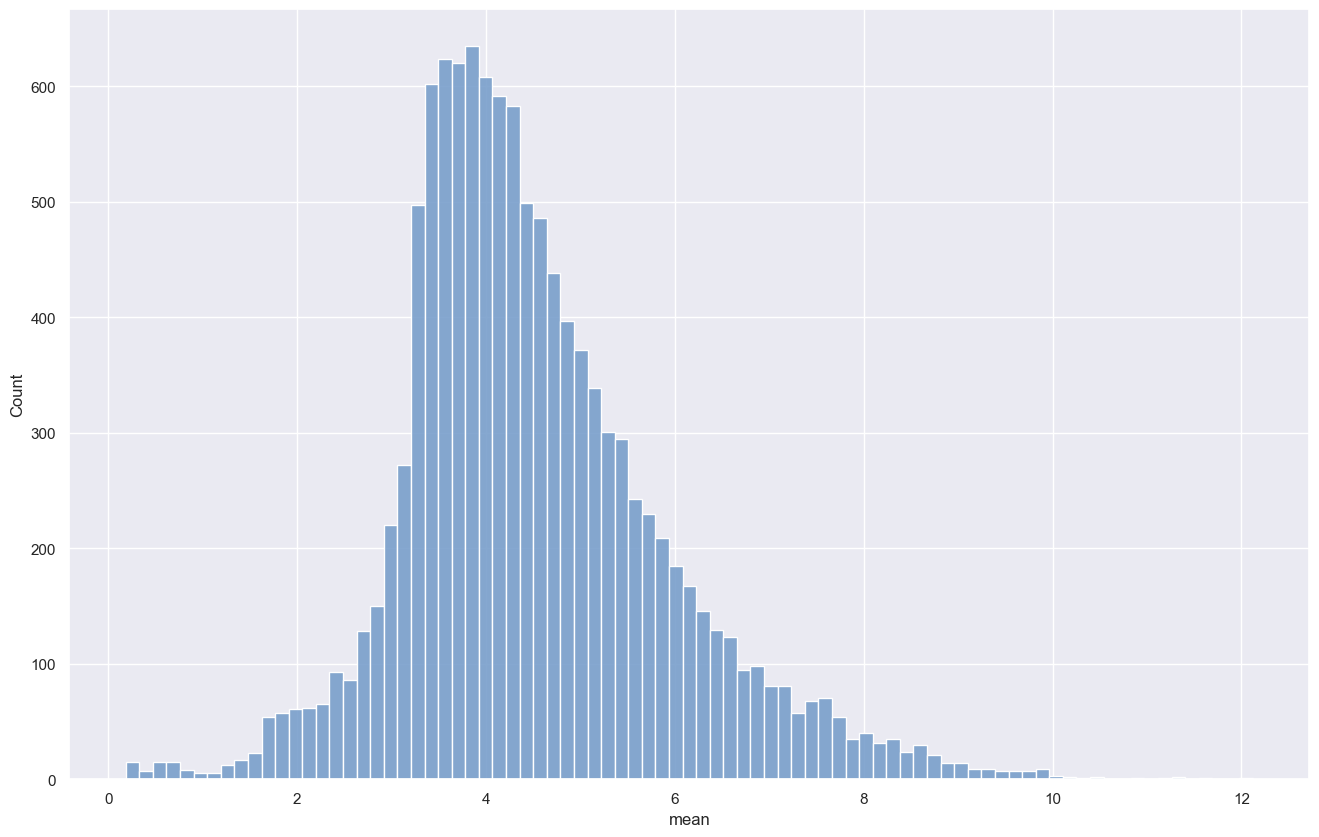

Function : numpy.amax
Genes below 10th percentile [   6.057606] :  1,160
Genes below 30th percentile [   6.972207] :  3,480
Genes above 70th percentile [   8.965341] :  3,480
Genes above 90th percentile [  10.858075] :  1,160



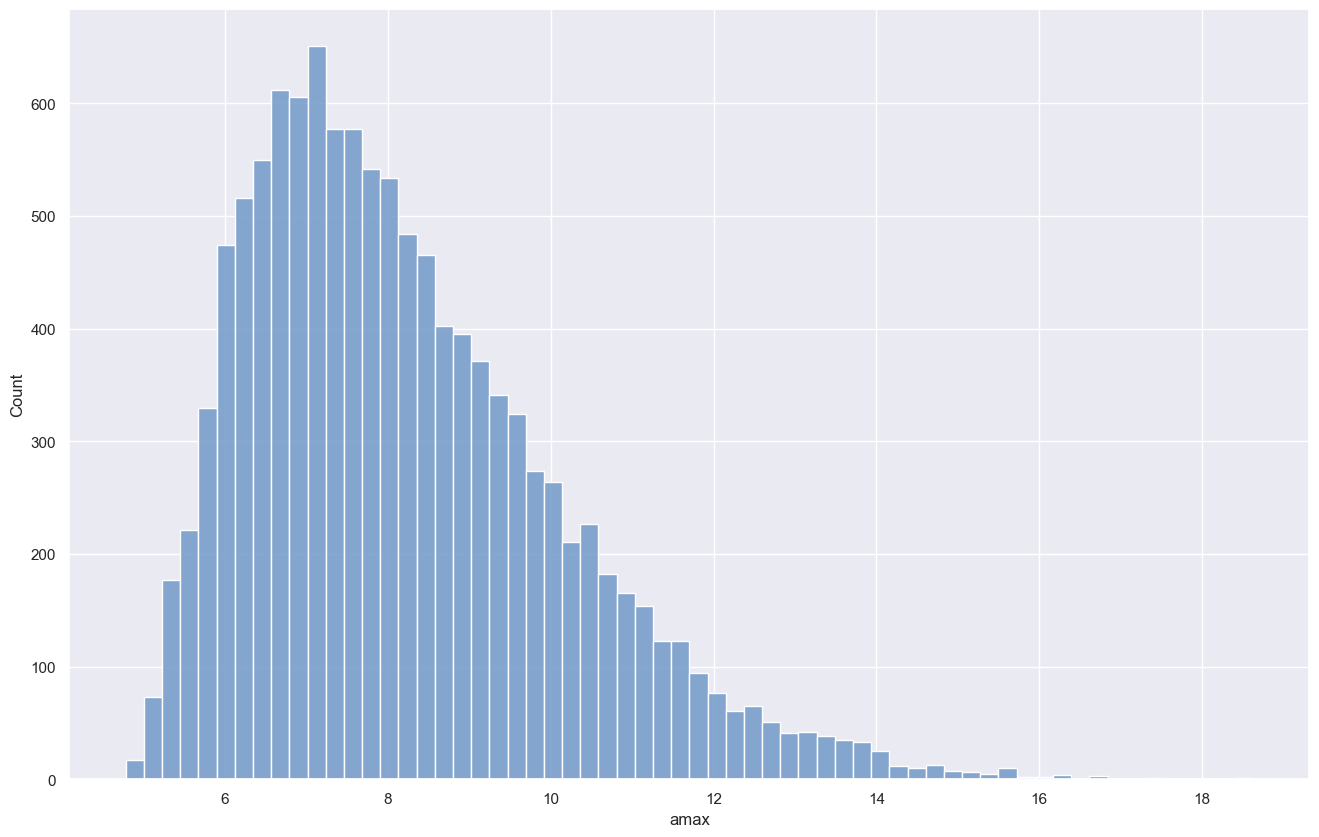

Function : numpy.std
Genes below 10th percentile [   0.727384] :  1,160
Genes below 30th percentile [   0.869782] :  3,480
Genes above 70th percentile [   1.354753] :  3,480
Genes above 90th percentile [   1.988267] :  1,160



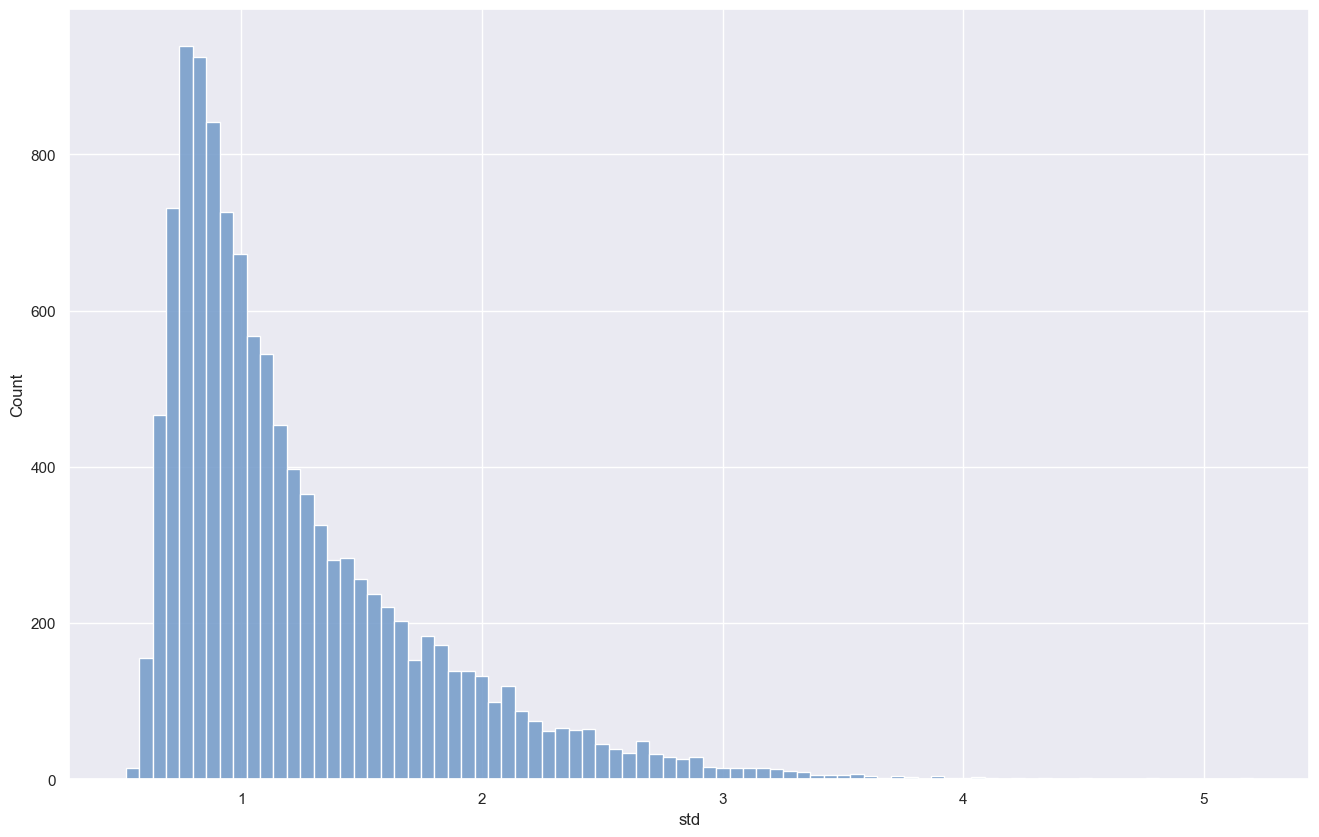

In [18]:
# Display log1p tpm value distribution per gene

for name, function in functions :
	if name == 'min' : continue

	feature_anndata.tpm_histplot(
		data     = anndata[:, keep_transcript],
		layer    = 'log1p',
		function = function,
		filters  = None,
		filename = os.path.join(OUT_PLOT, 'distribution-log1p-keep-' + name)
	)

	matplotlib.pyplot.show()

Function : numpy.mean
Genes below 10th percentile [   0.018803] :  1,582
Genes below 30th percentile [   0.140032] :  4,746
Genes above 70th percentile [   1.698487] :  4,746
Genes above 90th percentile [   2.686160] :  1,582



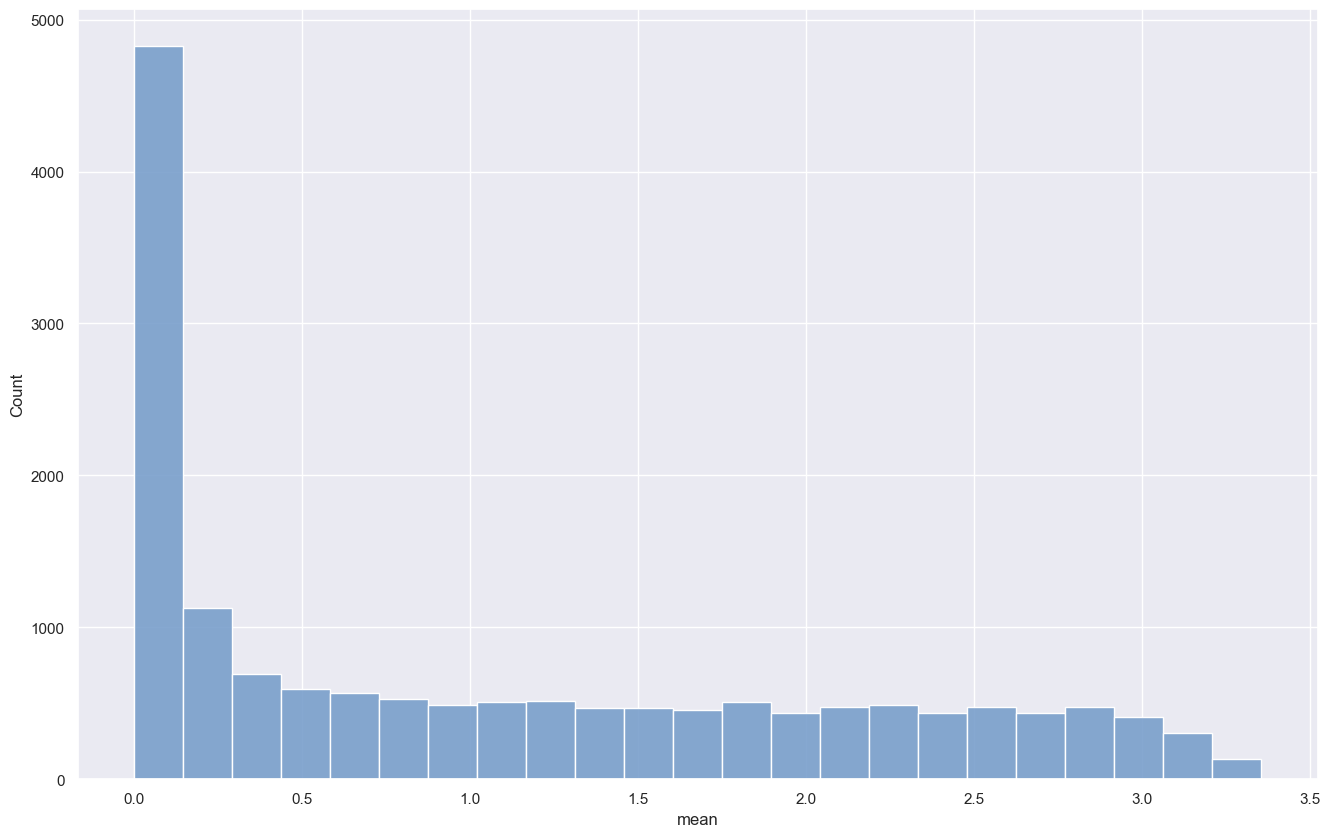

Function : numpy.amax
Genes below 10th percentile [   2.065597] :  1,582
Genes below 30th percentile [   3.993521] :  4,746
Genes above 70th percentile [   6.025671] :  4,746
Genes above 90th percentile [   7.716057] :  1,582



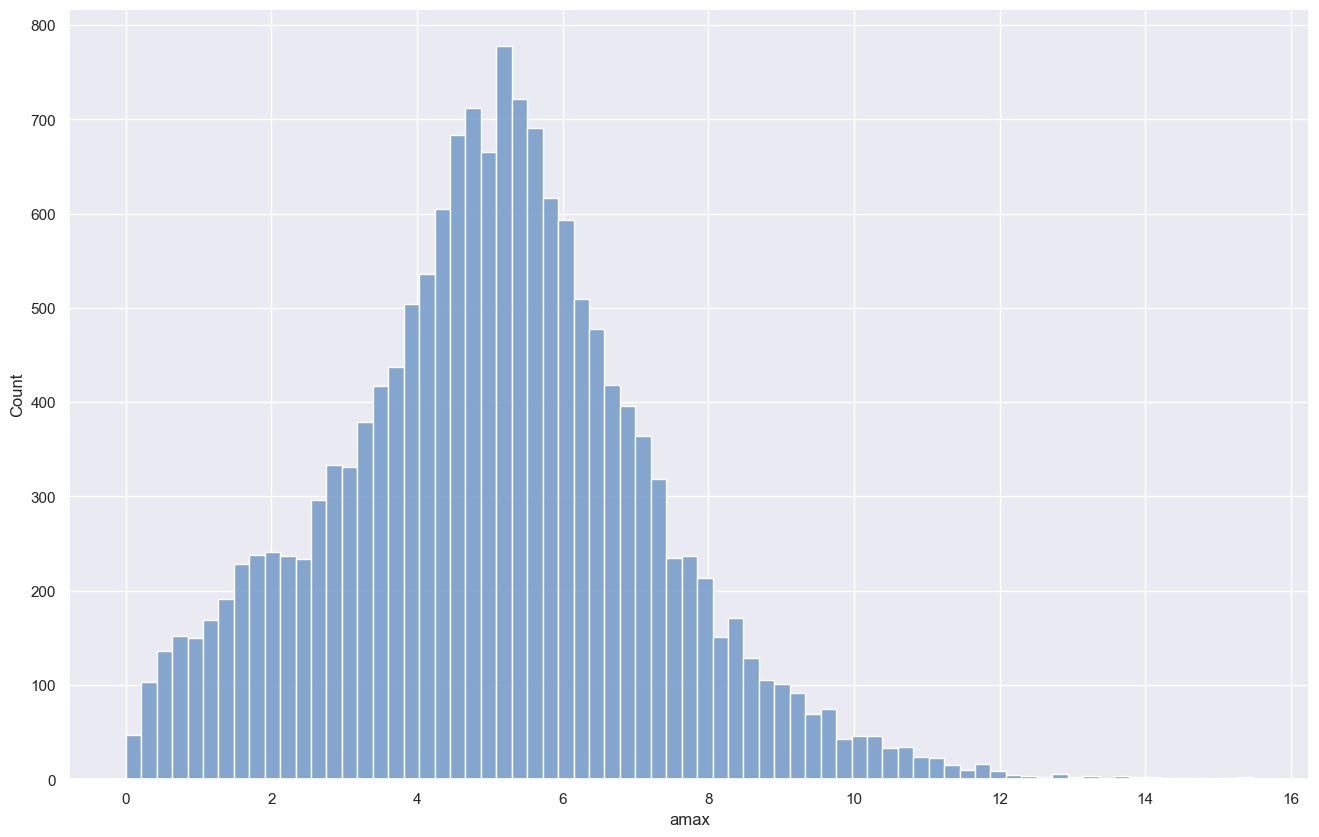

Function : numpy.std
Genes below 10th percentile [   0.117926] :  1,582
Genes below 30th percentile [   0.422559] :  4,746
Genes above 70th percentile [   0.909821] :  4,746
Genes above 90th percentile [   1.270453] :  1,582



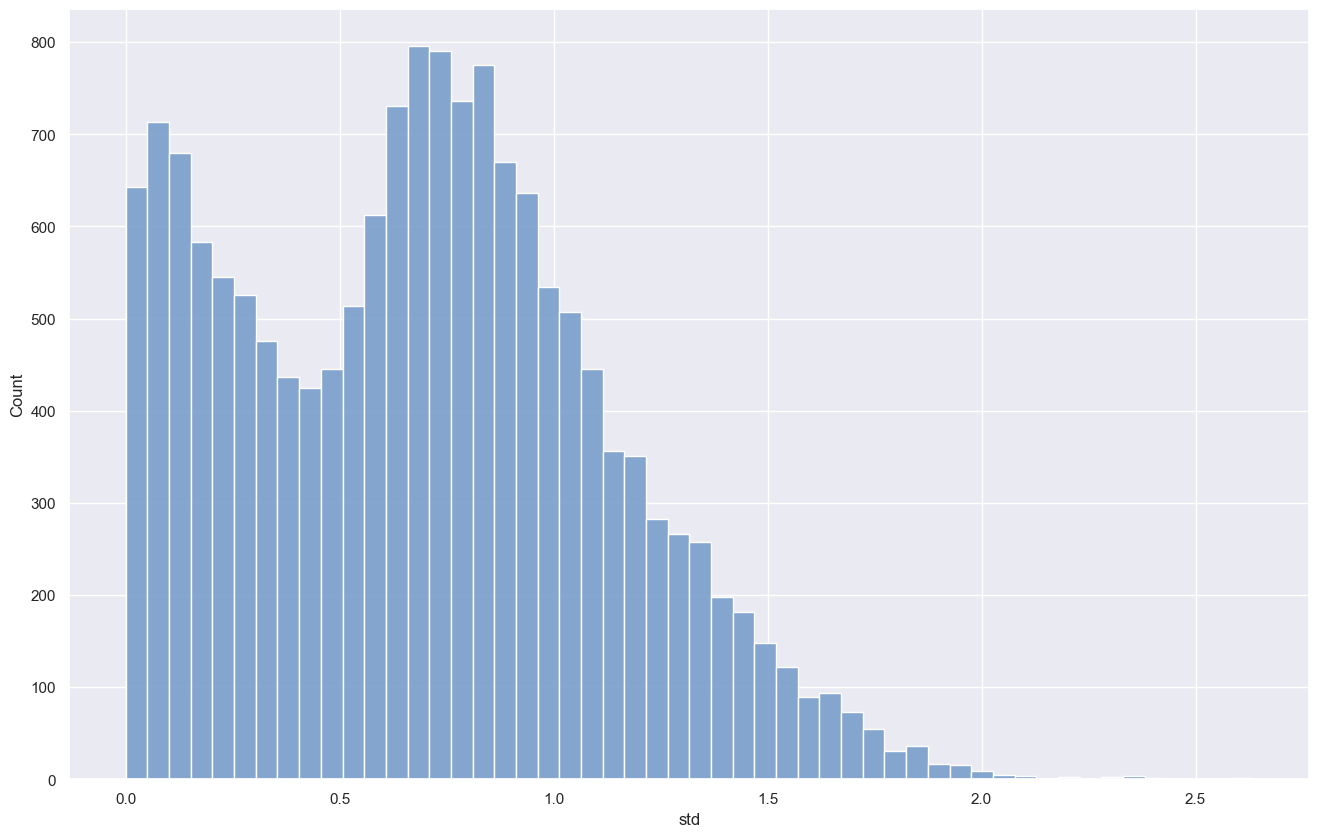

In [19]:
# Display log1p tpm value distribution per gene

for name, function in functions :
	if name == 'min' : continue

	feature_anndata.tpm_histplot(
		data     = anndata[:, drop_transcript],
		layer    = 'log1p',
		function = function,
		filters  = None,
		filename = os.path.join(OUT_PLOT, 'distribution-log1p-drop-' + name)
	)

	matplotlib.pyplot.show()

## 3.3 Transcripts

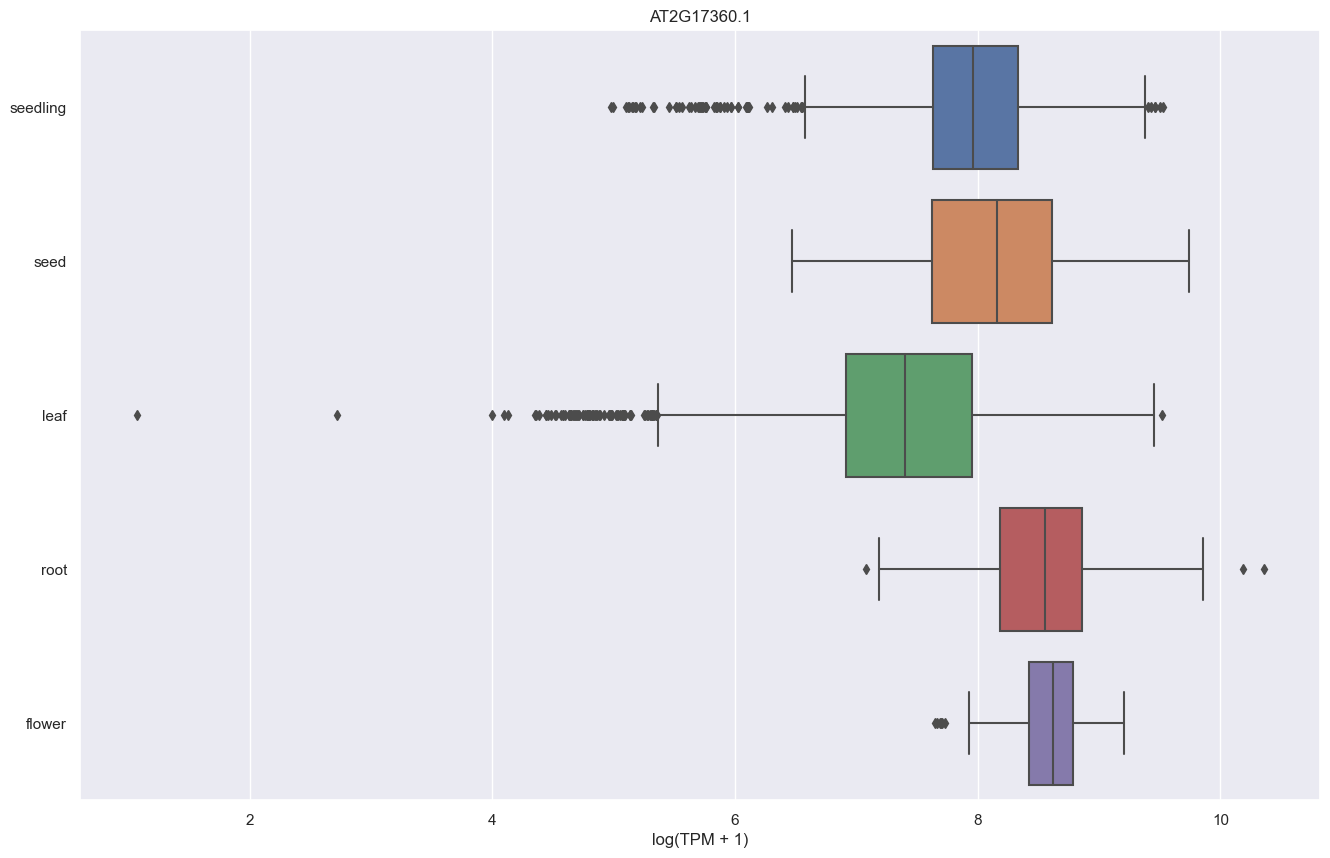

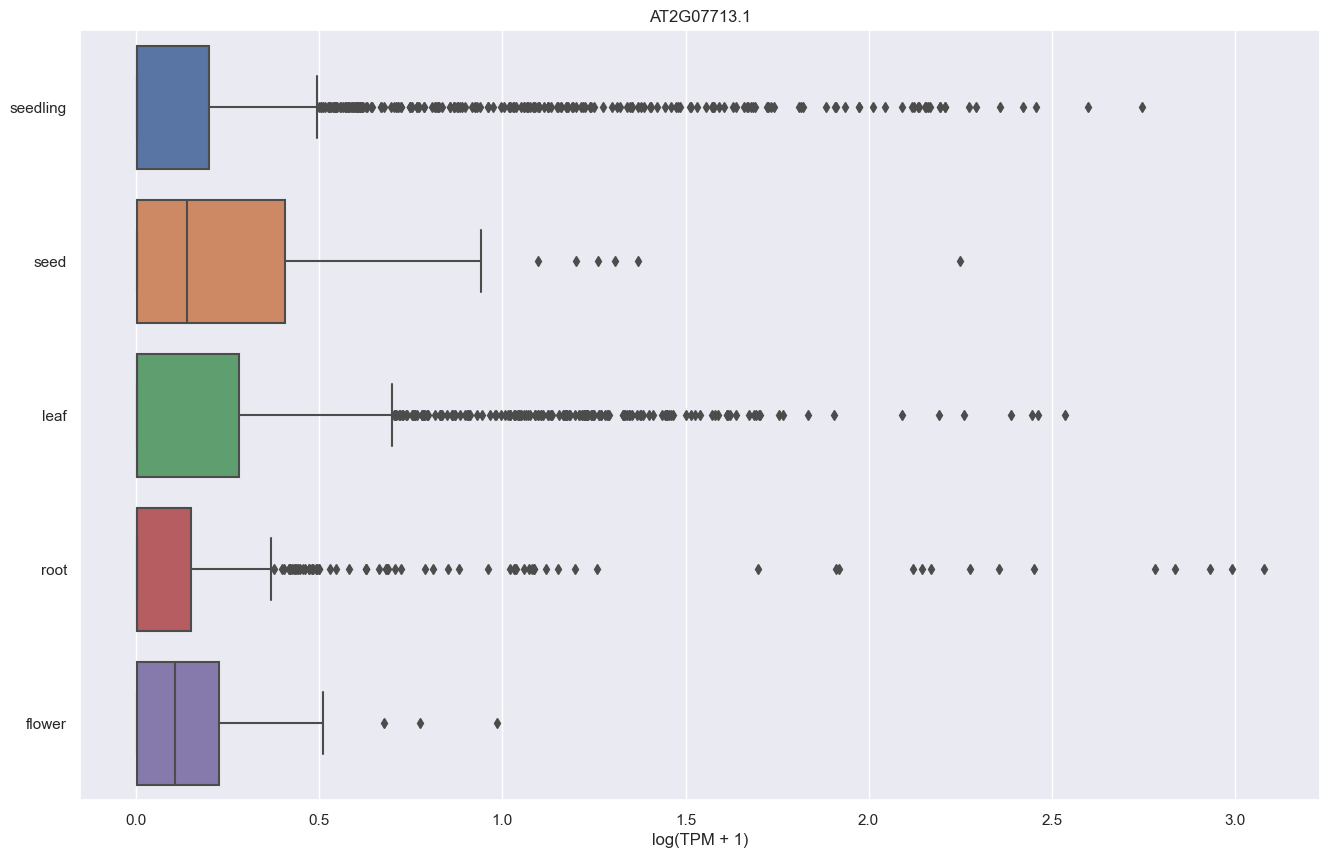

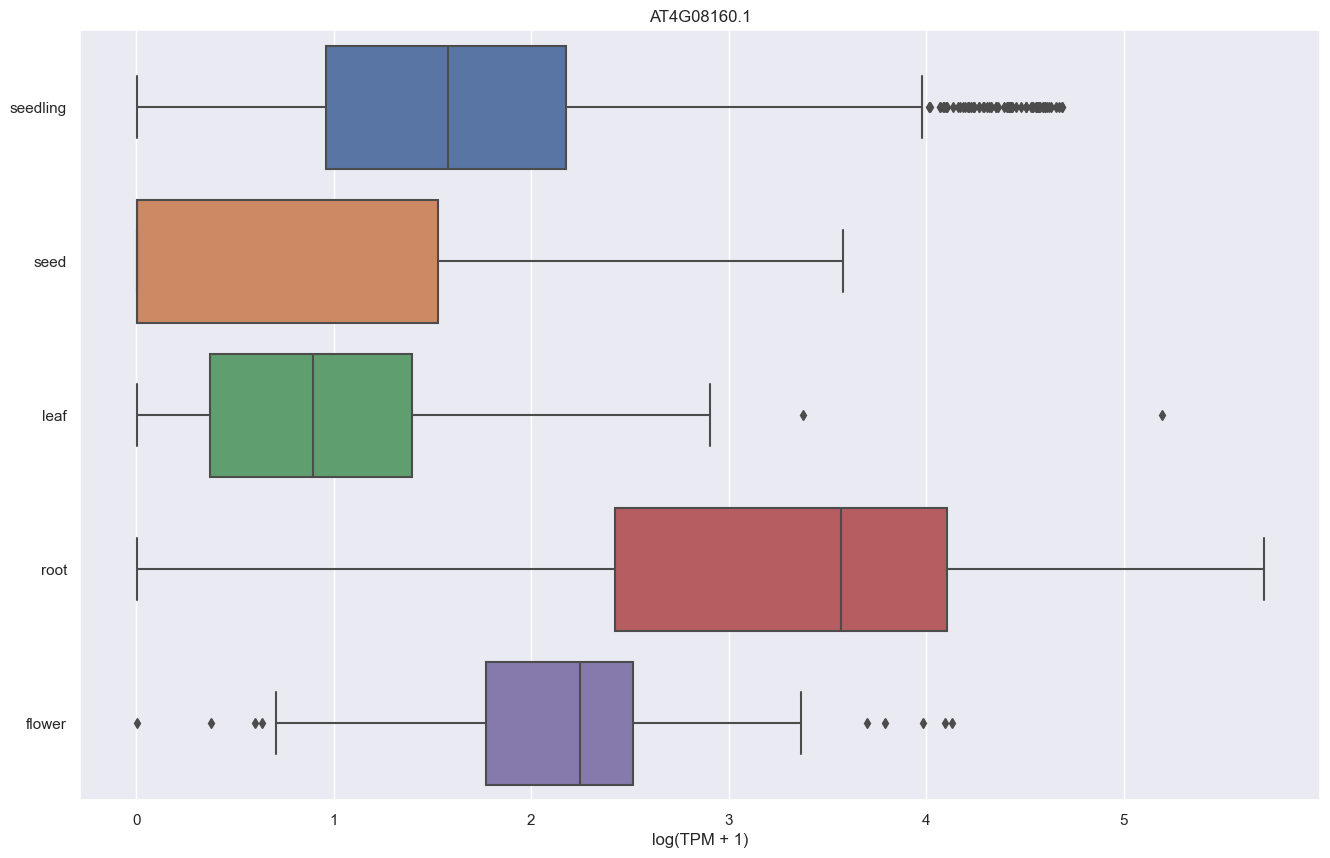

In [20]:
# Display an example of few transcript expressions per tissue

for transcript in boxplot_transcripts :
	if transcript not in anndata.var.index : continue

	feature_anndata.gene_boxplot(
		data       = anndata,
		transcript = transcript,
		groupby    = 'Tissue',
		layer      = 'log1p',
		filename   = os.path.join(OUT_PLOT, 'tissue-log1p-' + transcript)
	)

	matplotlib.pyplot.show()

# 4. BoxCox

In [21]:
# Compute and save the boxcox1p tpm values

anndata, boxcox_factors = feature_anndata.compute_boxcox1p(
	data       = anndata,
	store_into = 'boxcox1p',
	layer      = mapping['boxcox1p'],
	eps        =  1.0000000000000000,
	lmbda      = -0.1455266110158969
)

print('Lambda : {}'.format(boxcox_factors['lambda']))
print()

Lambda : -0.1455266110158969



In [22]:
# Display anndata boxcox1p tpm matrix information

feature_anndata.show_matrix(anndata, layer = 'boxcox1p')

   Max value :   5.82196
  Mean value :   1.40195 ± 1.19576
Median value :   1.39923
   Min value :   0.00000

Total elements        : 111,791,340
Total elements =  0.0 :           0 [  0.00 %]
Total elements >  0.0 : 111,791,340 [100.00 %]
Total elements >  1.0 :  64,123,434 [ 57.36 %]
Total elements >  2.0 :  40,023,838 [ 35.80 %]
Total elements >  3.0 :  11,345,150 [ 10.15 %]
Total elements >  4.0 :   1,141,298 [  1.02 %]
Total elements >  5.0 :      17,156 [  0.02 %]

[[  2.393   2.096   0.596   1.877   3.435   2.348   1.853   1.131   3.722   4.397]
 [  2.451   1.911   0.870   1.954   3.460   2.228   1.544   0.500   3.707   4.340]
 [  2.720   2.058   0.498   2.133   3.514   2.002   1.773   0.766   3.719   4.311]
 [  2.603   2.157   0.486   2.018   3.527   2.300   1.135   1.688   3.687   4.422]
 [  2.701   1.972   0.869   1.549   3.587   2.149   1.740   1.107   3.550   4.337]]


## 4.1 Statistics

In [23]:
# Compute basic statistics

dataframes = [
	analysis_statistics.generate_basic_statistics(
		data       = anndata[samples_tissue[tissue]].layers['boxcox1p'].T,
		transcript = transcripts,
		tissue     = tissue,
		axis       = 1
	)

	for tissue in samples_tissue.keys()
]

dataframes.append(
	analysis_statistics.generate_basic_statistics(
		data       = anndata.layers['boxcox1p'].T,
		transcript = transcripts,
		tissue     = 'Global',
		axis       = 1
	)
)

statistic_boxcox1p_basic = pandas.concat(dataframes).set_index(['Transcript', 'Tissue'])
statistic_boxcox1p_basic.xs(samples_name, level = 0)

,Count,Mean,Median,St. Deviation,Variance,Minimum,Maximum,Range,MAD
Tissue,,,,,,,,,
Seedling,1720,1.862,1.882,0.490,0.240,0.001,3.378,3.377,0.300
Seed,103,1.569,1.560,0.476,0.226,0.300,3.104,2.804,0.228
Leaf,1566,1.391,1.353,0.585,0.342,0.001,3.307,3.306,0.368
Root,606,2.475,2.618,0.497,0.247,0.631,3.493,2.862,0.185
Flower,82,1.683,1.633,0.305,0.093,1.117,2.565,1.448,0.205
Mature_Seedling,1059,1.814,1.854,0.468,0.219,0.285,3.339,3.054,0.290
Young_Seedling,643,1.954,1.911,0.511,0.261,0.001,3.378,3.377,0.319
Mature_Seed,103,1.569,1.560,0.476,0.226,0.300,3.104,2.804,0.228
Mature_Leaf,1442,1.344,1.301,0.565,0.319,0.001,3.212,3.211,0.348


In [24]:
# Compute advance statistics

dataframes = [
	analysis_statistics.genearte_advance_statistics(
		data       = anndata[samples_tissue[tissue]].layers['boxcox1p'].T,
		transcript = transcripts,
		tissue     = tissue,
		axis       = 1
	)

	for tissue in samples_tissue.keys()
]

dataframes.append(
	analysis_statistics.genearte_advance_statistics(
		data       = anndata.layers['boxcox1p'].T,
		transcript = transcripts,
		tissue     = 'Global',
		axis       = 1
	)
)

statistic_boxcox1p_advance = pandas.concat(dataframes).set_index(['Transcript', 'Tissue'])
statistic_boxcox1p_advance.xs(samples_name, level = 0)

,ZScore-Lower,ZScore-Upper,ZScore-Percent,IQR-Lower,IQR-Upper,IQR-Percent
Tissue,,,,,,
Seedling,0.391,3.333,0.999,0.676,3.066,0.977
Seed,0.142,2.996,0.990,0.633,2.427,0.932
Leaf,-0.365,3.146,0.998,-0.110,2.856,0.989
Root,0.983,3.967,1.000,1.780,3.334,0.893
Flower,0.767,2.599,1.000,0.834,2.444,0.976
Mature_Seedling,0.411,3.218,0.998,0.659,3.011,0.975
Young_Seedling,0.422,3.485,1.000,0.690,3.336,0.992
Mature_Seed,0.142,2.996,0.990,0.633,2.427,0.932
Mature_Leaf,-0.350,3.038,0.998,-0.097,2.753,0.985


In [25]:
# Compute normality statistics

with warnings.catch_warnings() :
	warnings.simplefilter('ignore')

	dataframes = [
		analysis_statistics.generate_normality_statistics(
			data       = anndata[samples_tissue[tissue]].layers['boxcox1p'].T,
			transcript = transcripts,
			tissue     = tissue
		)

		for tissue in samples_tissue.keys()
	]

	dataframes.append(
		analysis_statistics.generate_normality_statistics(
			data       = anndata.layers['boxcox1p'].T,
			transcript = transcripts,
			tissue     = 'Global'
		)
	)

statistic_boxcox1p_normality = pandas.concat(dataframes).set_index(['Transcript', 'Tissue'])
statistic_boxcox1p_normality.xs(samples_name, level = 0)

,Shapiro-Statistic,Shapiro-pValue,NormalTest-Statistic,NormalTest-pValue,Anderson-Statistic,Anderson-CriticalValue,Anderson-Significance
Tissue,,,,,,,
Seedling,0.993,0.000,29.924,0.000,3.180,1.089,1.000
Seed,0.947,0.000,14.700,0.001,1.835,1.054,1.000
Leaf,0.991,0.000,26.157,0.000,3.553,1.089,1.000
Root,0.869,0.000,154.635,0.000,27.896,1.085,1.000
Flower,0.962,0.017,5.558,0.062,1.032,1.045,1.000
Mature_Seedling,0.987,0.000,31.056,0.000,3.830,1.088,1.000
Young_Seedling,0.985,0.000,10.456,0.005,2.881,1.085,1.000
Mature_Seed,0.947,0.000,14.700,0.001,1.835,1.054,1.000
Mature_Leaf,0.992,0.000,20.381,0.000,2.800,1.089,1.000


## 4.2 Distribution

Function : numpy.mean
Genes below 10th percentile [   1.777782] :  1,160
Genes below 30th percentile [   2.117655] :  3,480
Genes above 70th percentile [   2.689385] :  3,480
Genes above 90th percentile [   3.227077] :  1,160



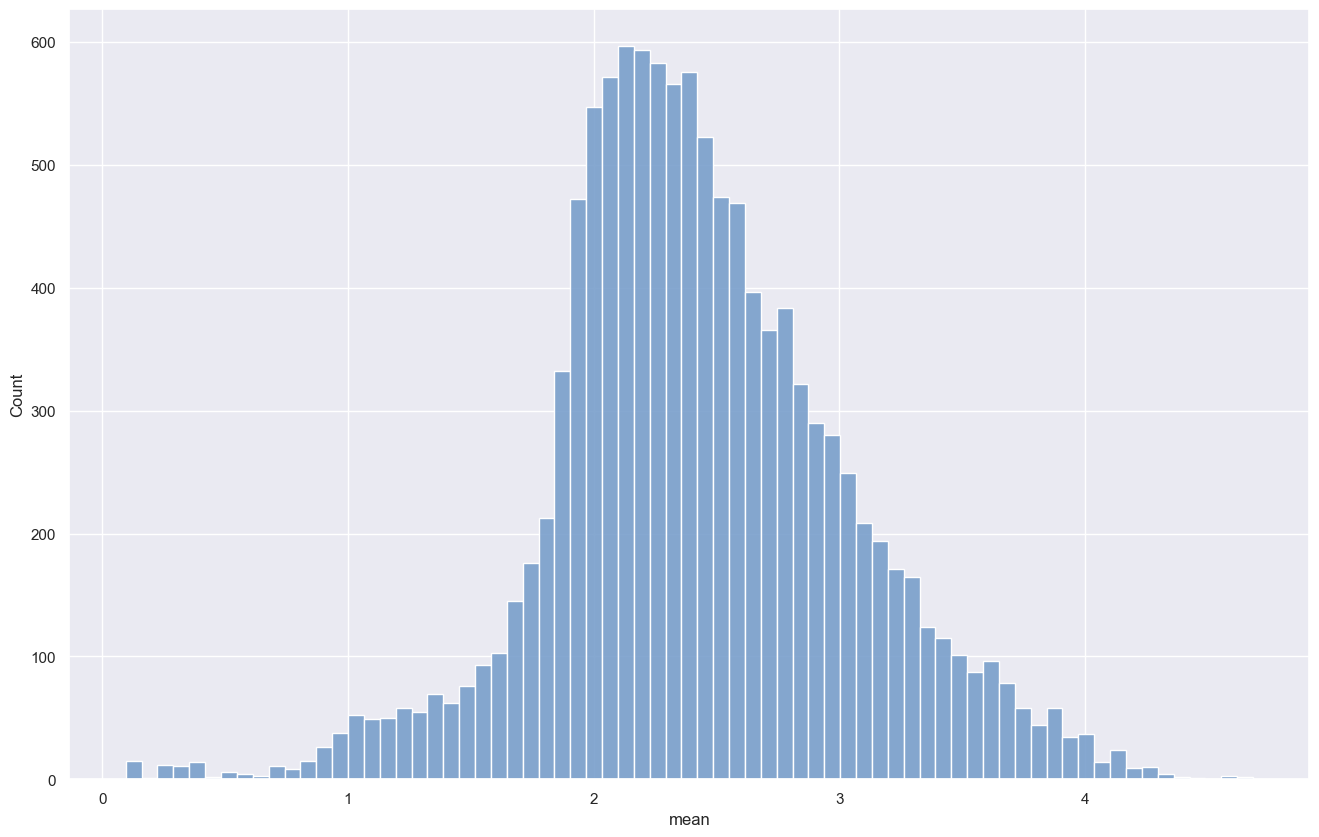

Function : numpy.amax
Genes below 10th percentile [   3.141785] :  1,160
Genes below 30th percentile [   3.470491] :  3,480
Genes above 70th percentile [   4.089929] :  3,480
Genes above 90th percentile [   4.573393] :  1,160



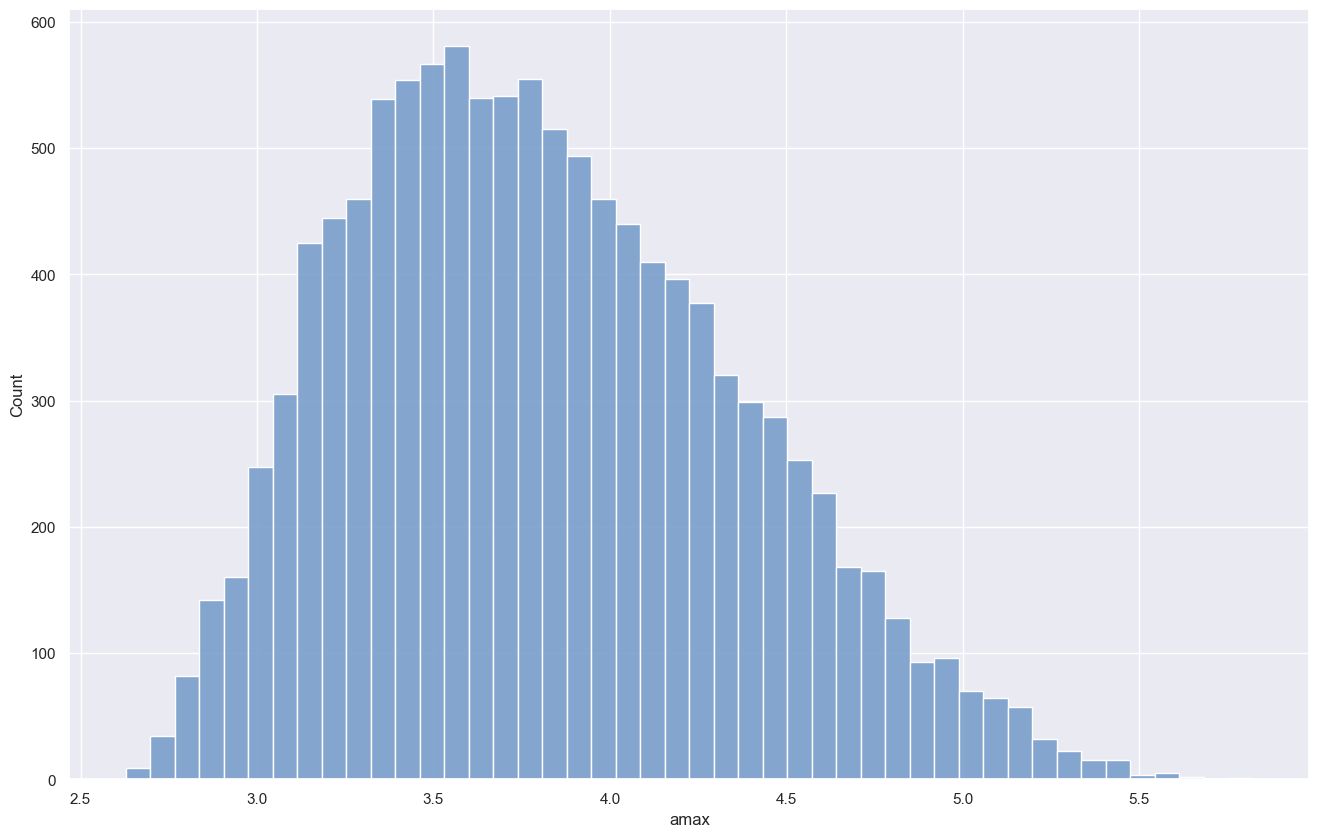

Function : numpy.std
Genes below 10th percentile [   0.327404] :  1,160
Genes below 30th percentile [   0.391422] :  3,480
Genes above 70th percentile [   0.628258] :  3,480
Genes above 90th percentile [   0.962493] :  1,160



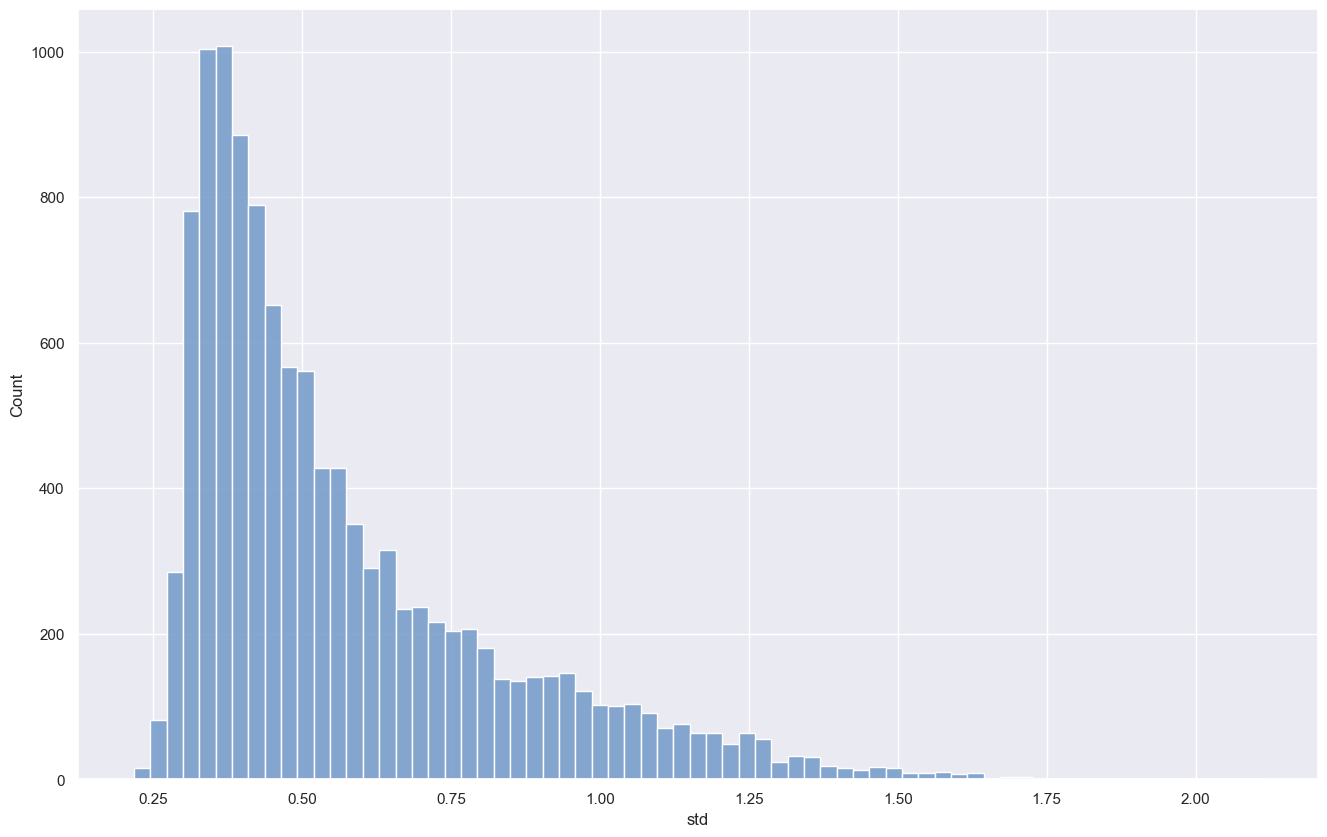

In [26]:
# Display boxcox1p tpm value distribution per gene

for name, function in functions :
	if name == 'min' : continue

	feature_anndata.tpm_histplot(
		data     = anndata[:, keep_transcript],
		layer    = 'boxcox1p',
		function = function,
		filters  = None,
		filename = os.path.join(OUT_PLOT, 'distribution-boxcox1p-keep-' + name)
	)

	matplotlib.pyplot.show()

Function : numpy.mean
Genes below 10th percentile [   0.012269] :  1,582
Genes below 30th percentile [   0.089081] :  4,746
Genes above 70th percentile [   1.046676] :  4,746
Genes above 90th percentile [   1.603886] :  1,582



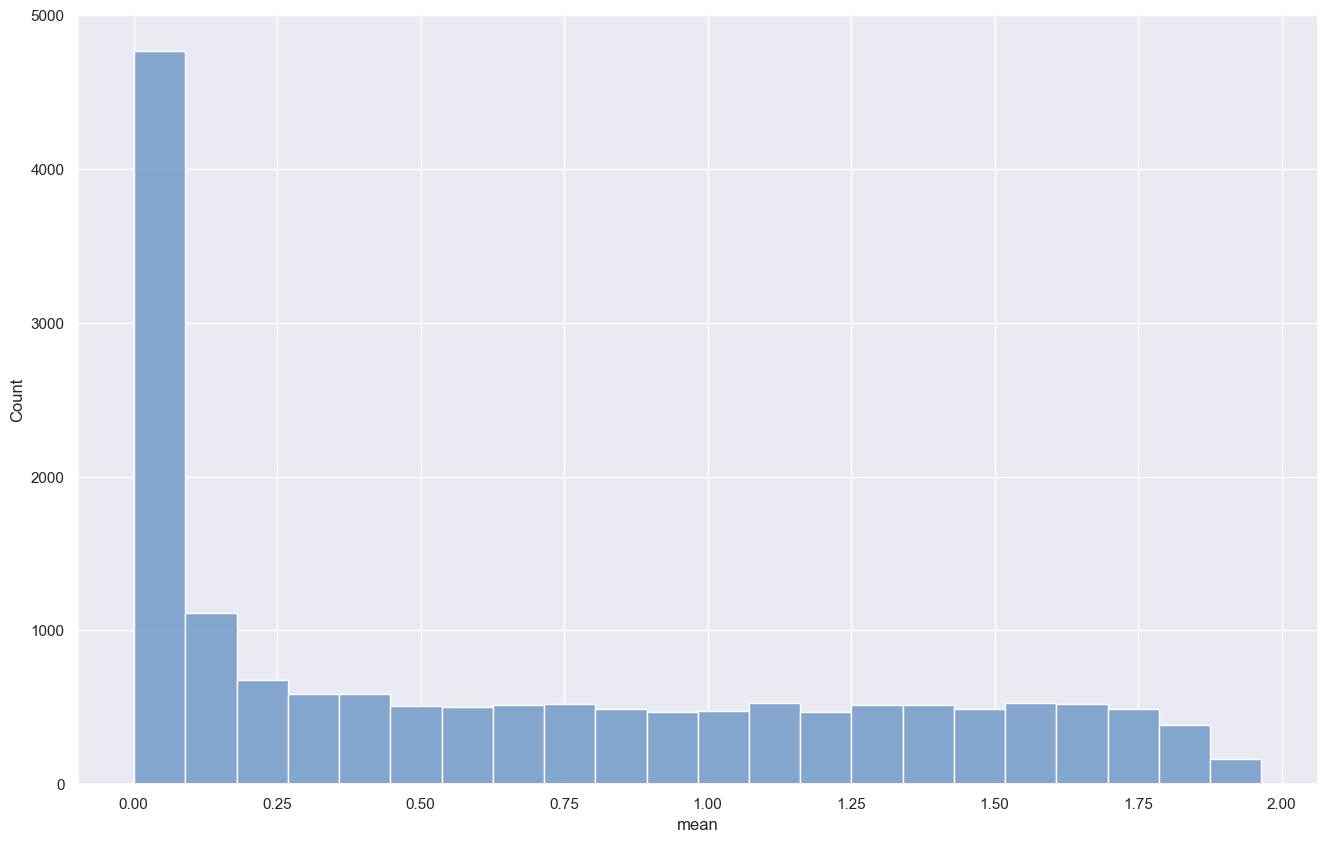

Function : numpy.amax
Genes below 10th percentile [   1.292444] :  1,582
Genes below 30th percentile [   2.278453] :  4,746
Genes above 70th percentile [   3.129751] :  4,746
Genes above 90th percentile [   3.716347] :  1,582



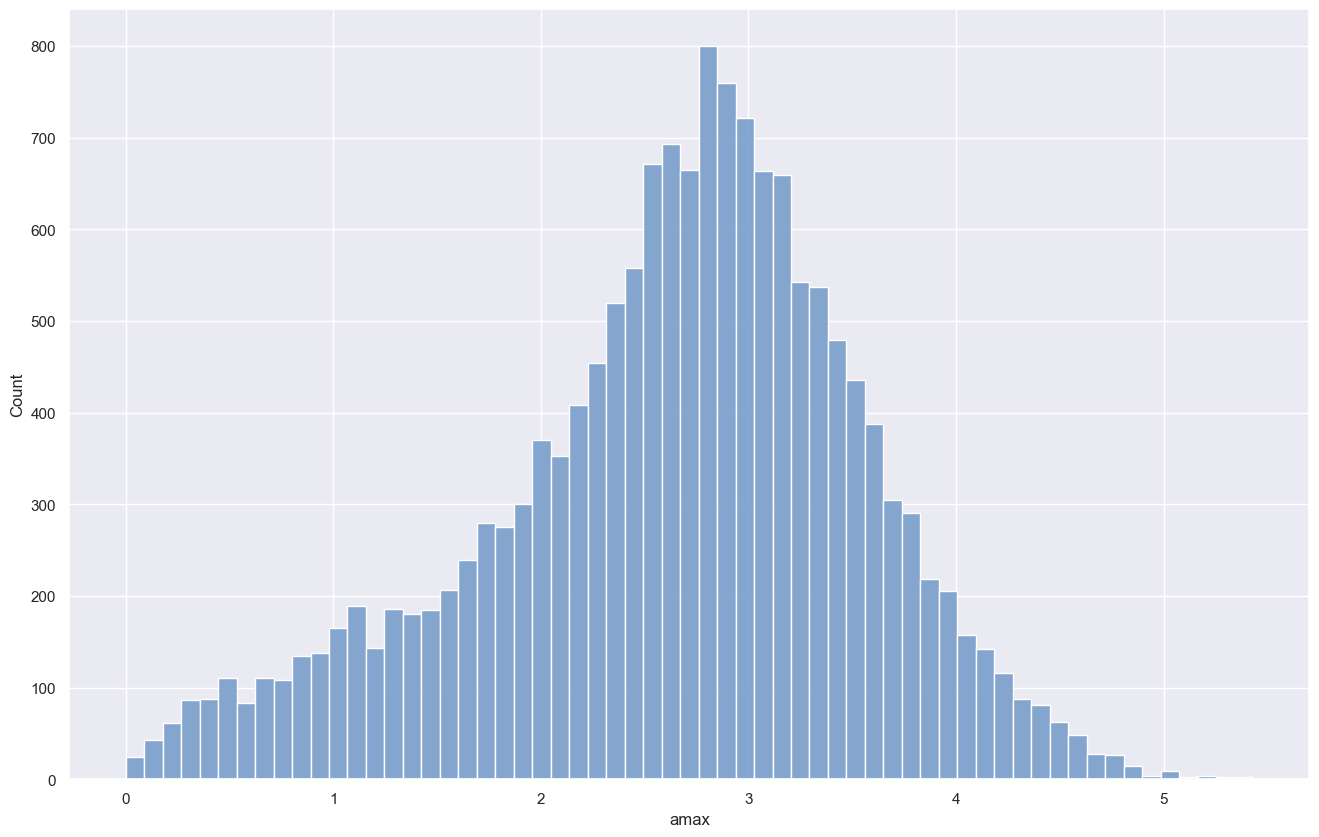

Function : numpy.std
Genes below 10th percentile [   0.076657] :  1,582
Genes below 30th percentile [   0.257130] :  4,746
Genes above 70th percentile [   0.514036] :  4,746
Genes above 90th percentile [   0.707036] :  1,582



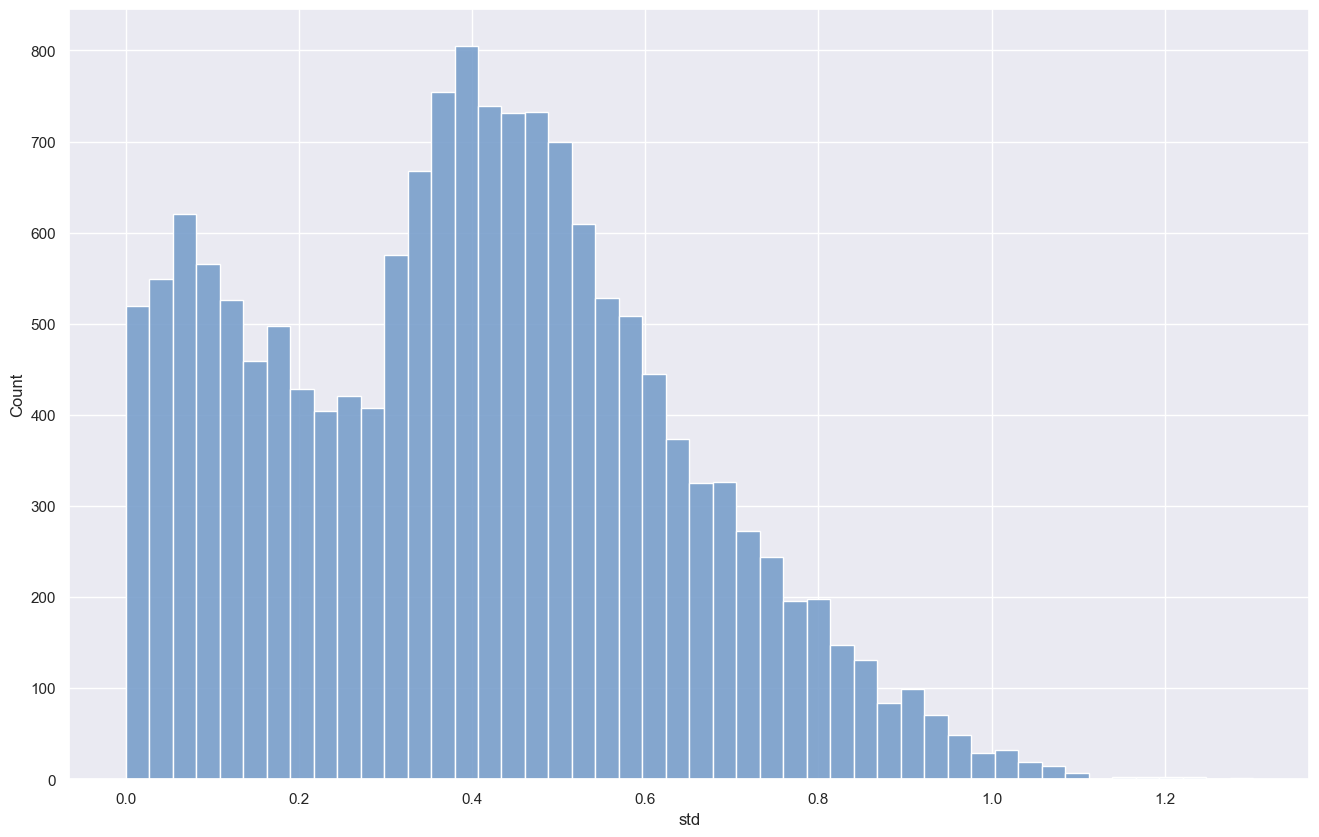

In [27]:
# Display boxcox1p tpm value distribution per gene

for name, function in functions :
	if name == 'min' : continue

	feature_anndata.tpm_histplot(
		data     = anndata[:, drop_transcript],
		layer    = 'boxcox1p',
		function = function,
		filters  = None,
		filename = os.path.join(OUT_PLOT, 'distribution-boxcox1p-drop-' + name)
	)

	matplotlib.pyplot.show()

## 4.3 Transcripts

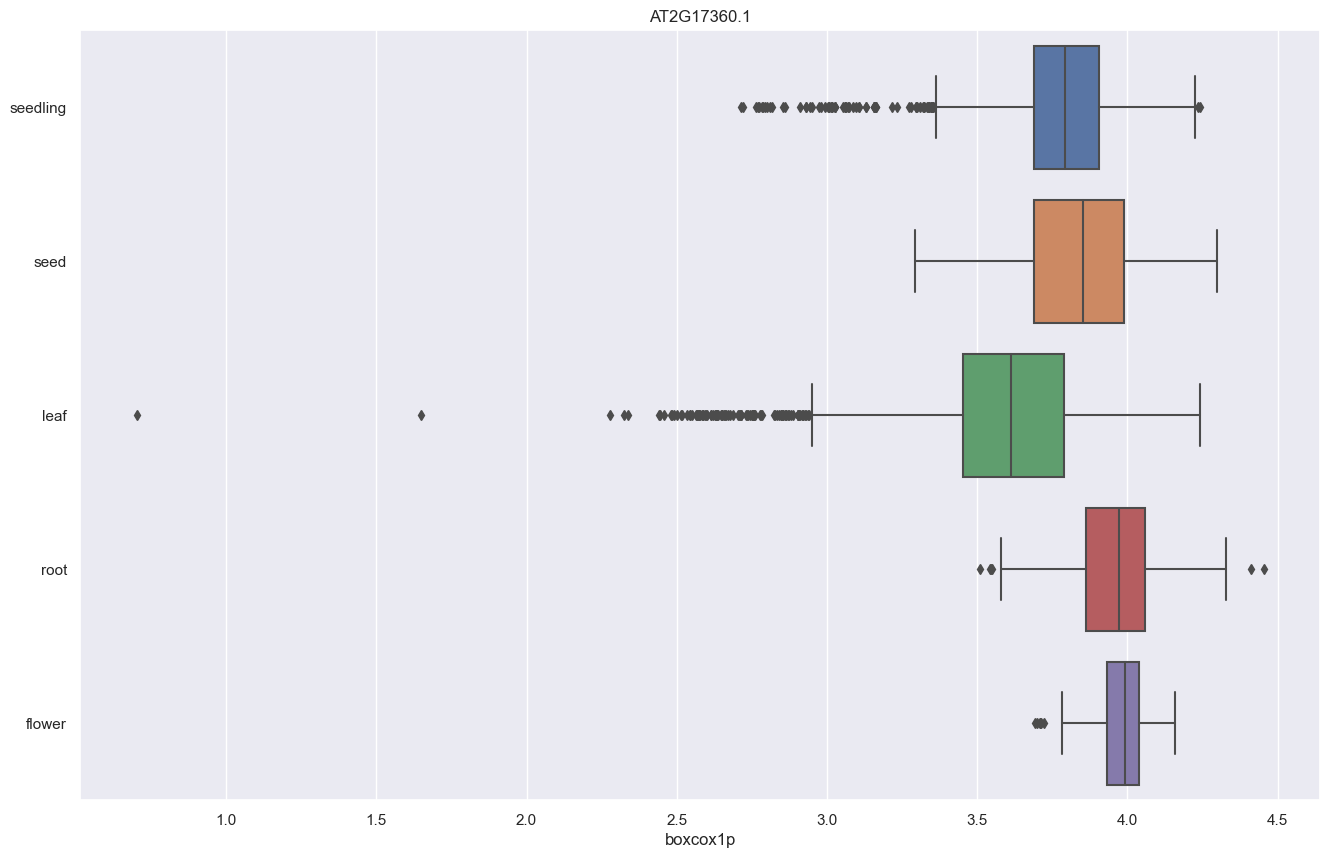

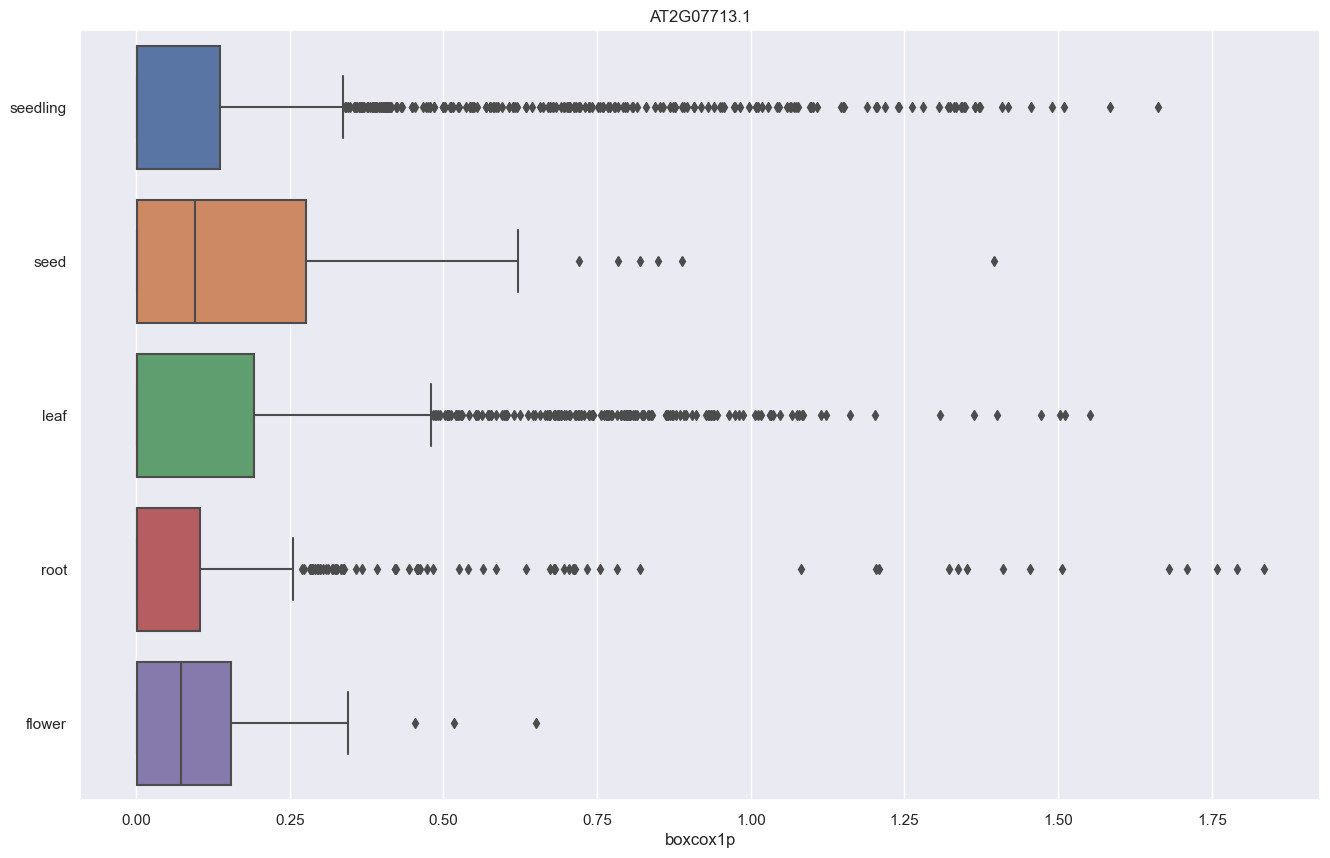

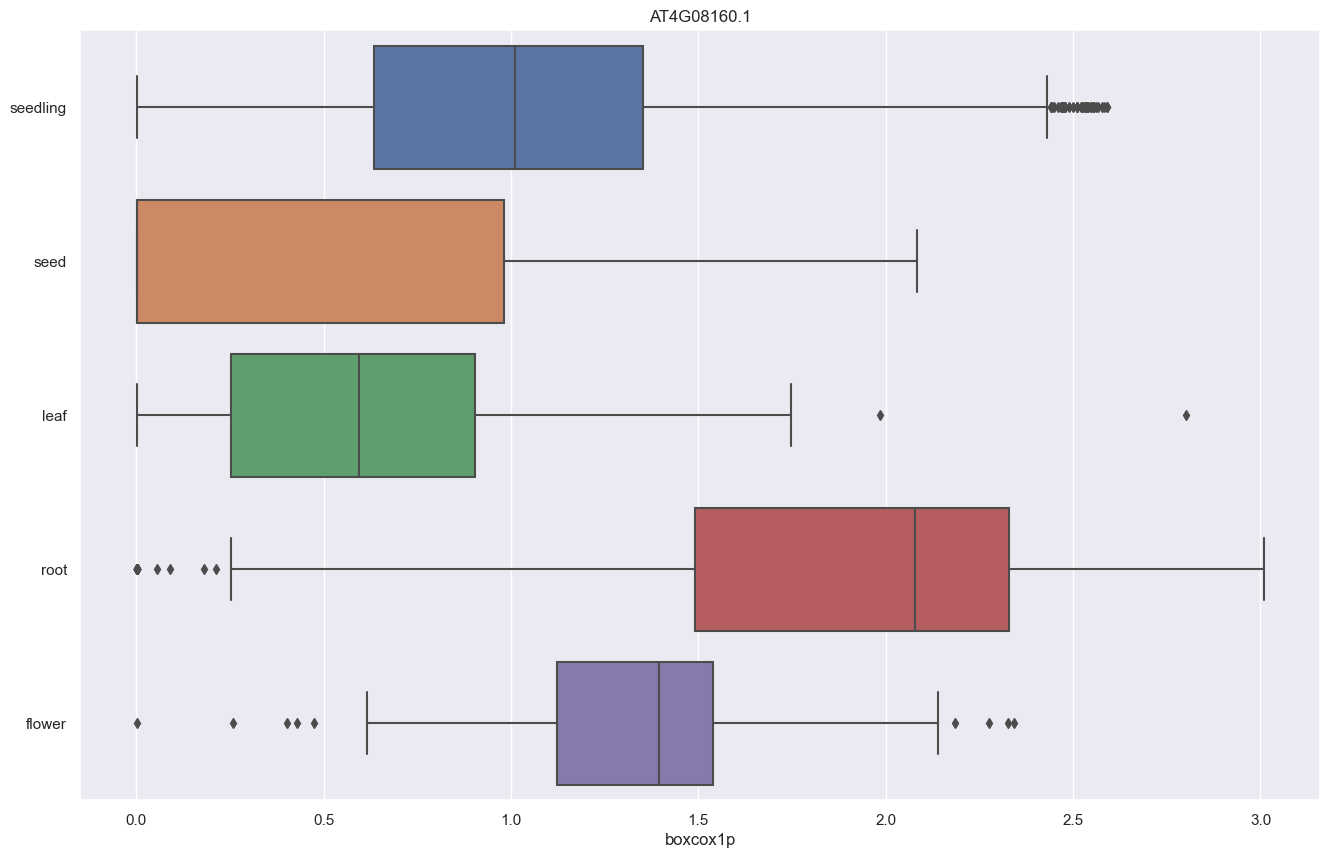

In [28]:
# Display an example of few transcript expressions per tissue

for transcript in boxplot_transcripts :
	if transcript not in anndata.var.index : continue

	feature_anndata.gene_boxplot(
		data       = anndata,
		transcript = transcript,
		groupby    = 'Tissue',
		layer      = 'boxcox1p',
		filename   = os.path.join(OUT_PLOT, 'tissue-boxcox1p-' + transcript)
	)

	matplotlib.pyplot.show()

# 5. Normal

In [29]:
# Compute and save the normalized tpm values

anndata, normal_factors = feature_anndata.compute_normalized(
	data       = anndata,
	layer      = mapping['normal'],
	store_into = 'normal'
)

print('Min : {}'.format(normal_factors['min']))
print('Max : {}'.format(normal_factors['max']))
print()

Min : 1.0354999843636617e-11
Max : 5.821963042782728



In [30]:
# Display normalized log1p tpm matrix information

feature_anndata.show_matrix(anndata, layer = 'normal')

   Max value :   1.00000
  Mean value :   0.24080 ± 0.20539
Median value :   0.24034
   Min value :   0.00000

Total elements        : 111,791,340
Total elements =  0.0 :           1 [  0.00 %]
Total elements >  0.0 : 111,791,339 [100.00 %]
Total elements >  0.1 :  71,664,946 [ 64.11 %]
Total elements >  0.3 :  47,292,069 [ 42.30 %]
Total elements >  0.5 :  13,223,452 [ 11.83 %]
Total elements >  0.7 :     898,655 [  0.80 %]

[[  0.411   0.360   0.102   0.322   0.590   0.403   0.318   0.194   0.639   0.755]
 [  0.421   0.328   0.150   0.336   0.594   0.383   0.265   0.086   0.637   0.745]
 [  0.467   0.354   0.086   0.366   0.604   0.344   0.304   0.132   0.639   0.741]
 [  0.447   0.371   0.083   0.347   0.606   0.395   0.195   0.290   0.633   0.760]
 [  0.464   0.339   0.149   0.266   0.616   0.369   0.299   0.190   0.610   0.745]]


## 5.1 Distribution

Function : numpy.mean
Genes below 10th percentile [   0.305358] :  1,160
Genes below 30th percentile [   0.363736] :  3,480
Genes above 70th percentile [   0.461938] :  3,480
Genes above 90th percentile [   0.554294] :  1,160



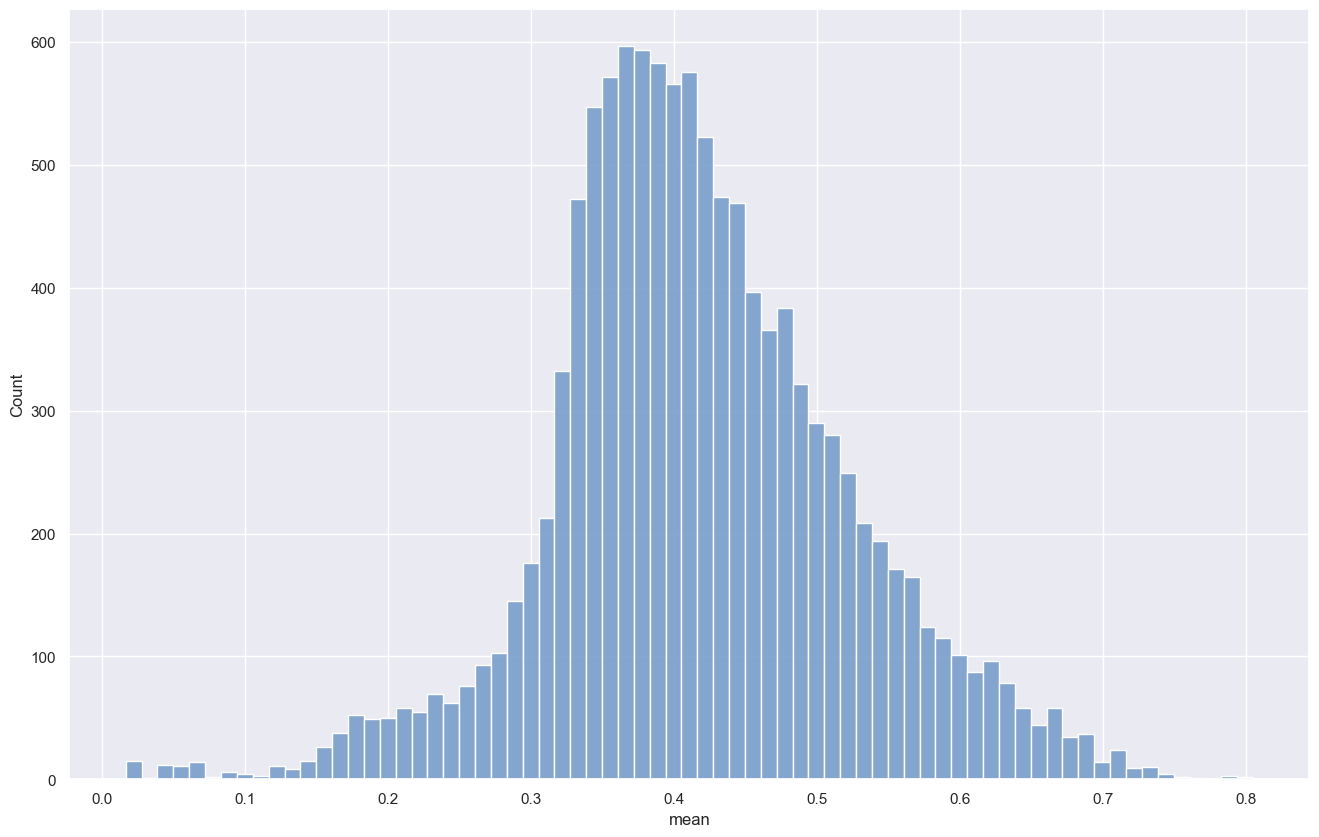

Function : numpy.amax
Genes below 10th percentile [   0.539644] :  1,160
Genes below 30th percentile [   0.596103] :  3,480
Genes above 70th percentile [   0.702500] :  3,480
Genes above 90th percentile [   0.785541] :  1,160



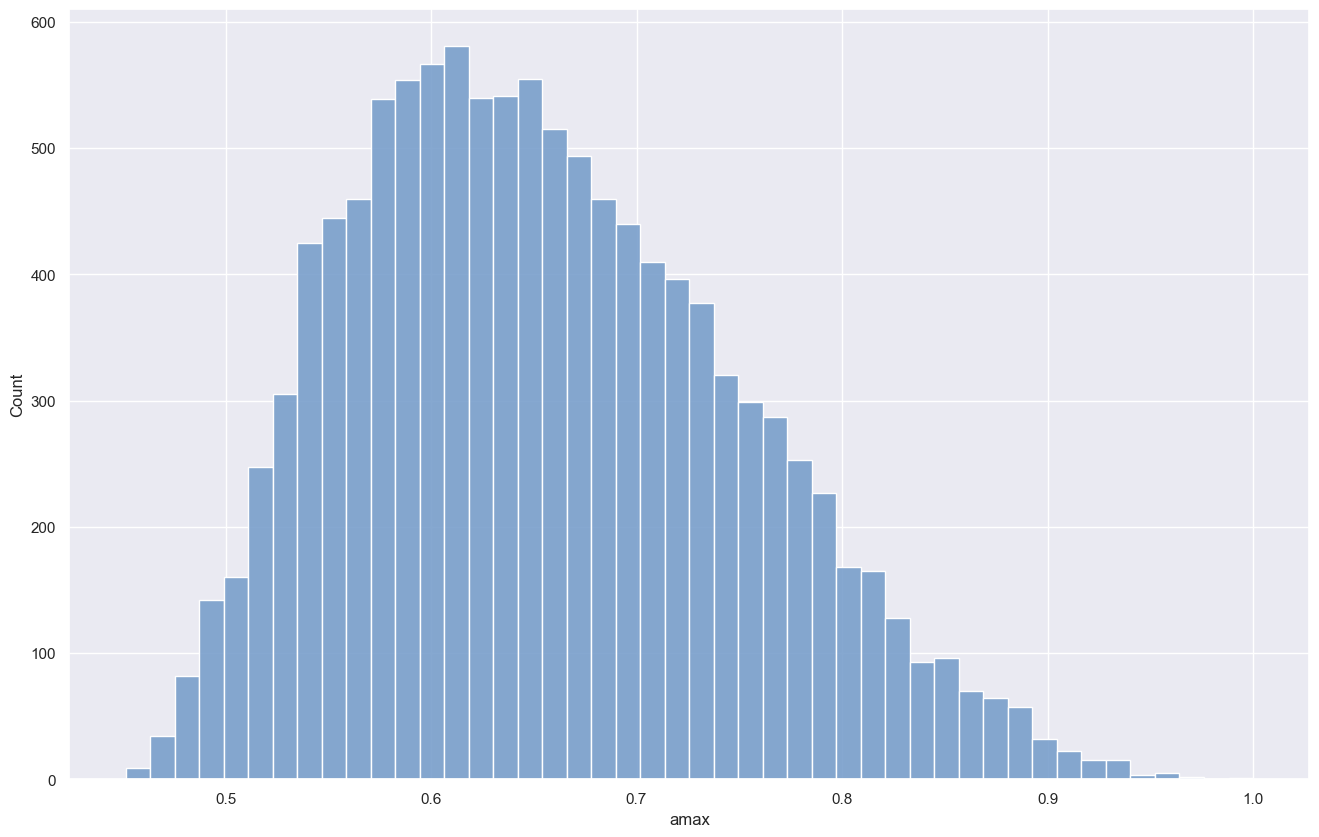

Function : numpy.std
Genes below 10th percentile [   0.056236] :  1,160
Genes below 30th percentile [   0.067232] :  3,480
Genes above 70th percentile [   0.107912] :  3,480
Genes above 90th percentile [   0.165321] :  1,160



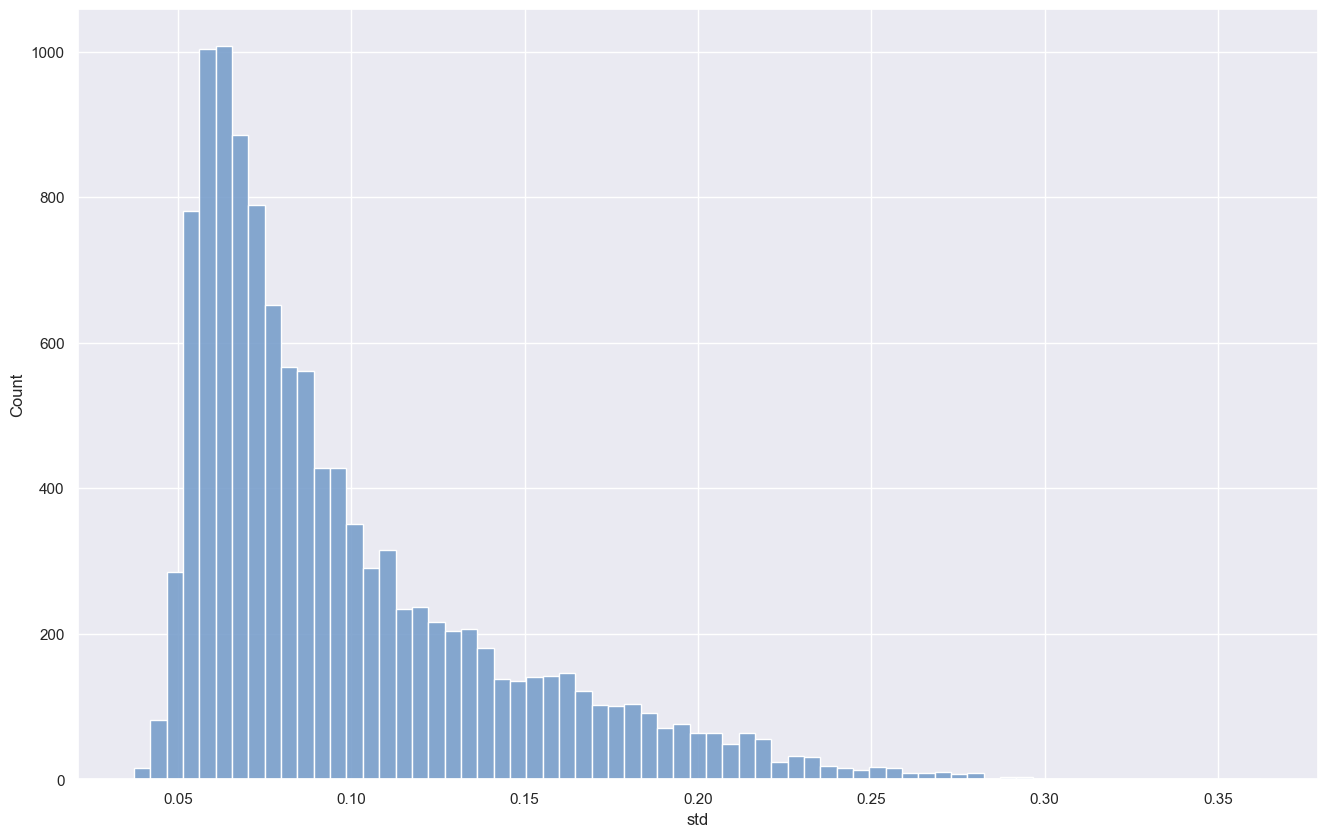

In [31]:
# Display normal tpm value distribution per gene

for name, function in functions :
	if name == 'min' : continue

	feature_anndata.tpm_histplot(
		data     = anndata[:, keep_transcript],
		layer    = 'normal',
		function = function,
		filters  = None,
		filename = os.path.join(OUT_PLOT, 'distribution-nornal-keep-' + name)
	)

	matplotlib.pyplot.show()

Function : numpy.mean
Genes below 10th percentile [   0.002107] :  1,582
Genes below 30th percentile [   0.015301] :  4,746
Genes above 70th percentile [   0.179781] :  4,746
Genes above 90th percentile [   0.275489] :  1,582



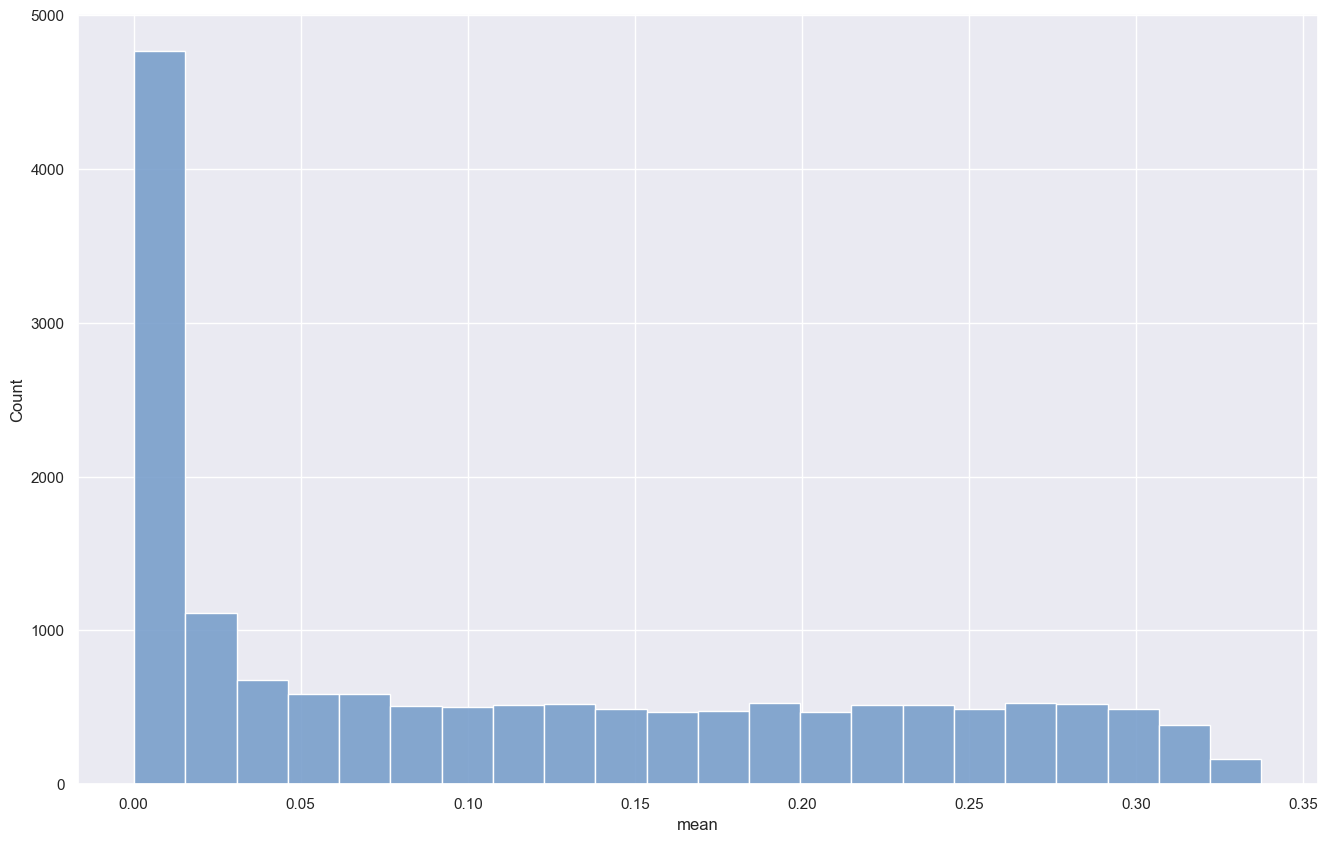

Function : numpy.amax
Genes below 10th percentile [   0.221995] :  1,582
Genes below 30th percentile [   0.391355] :  4,746
Genes above 70th percentile [   0.537577] :  4,746
Genes above 90th percentile [   0.638332] :  1,582



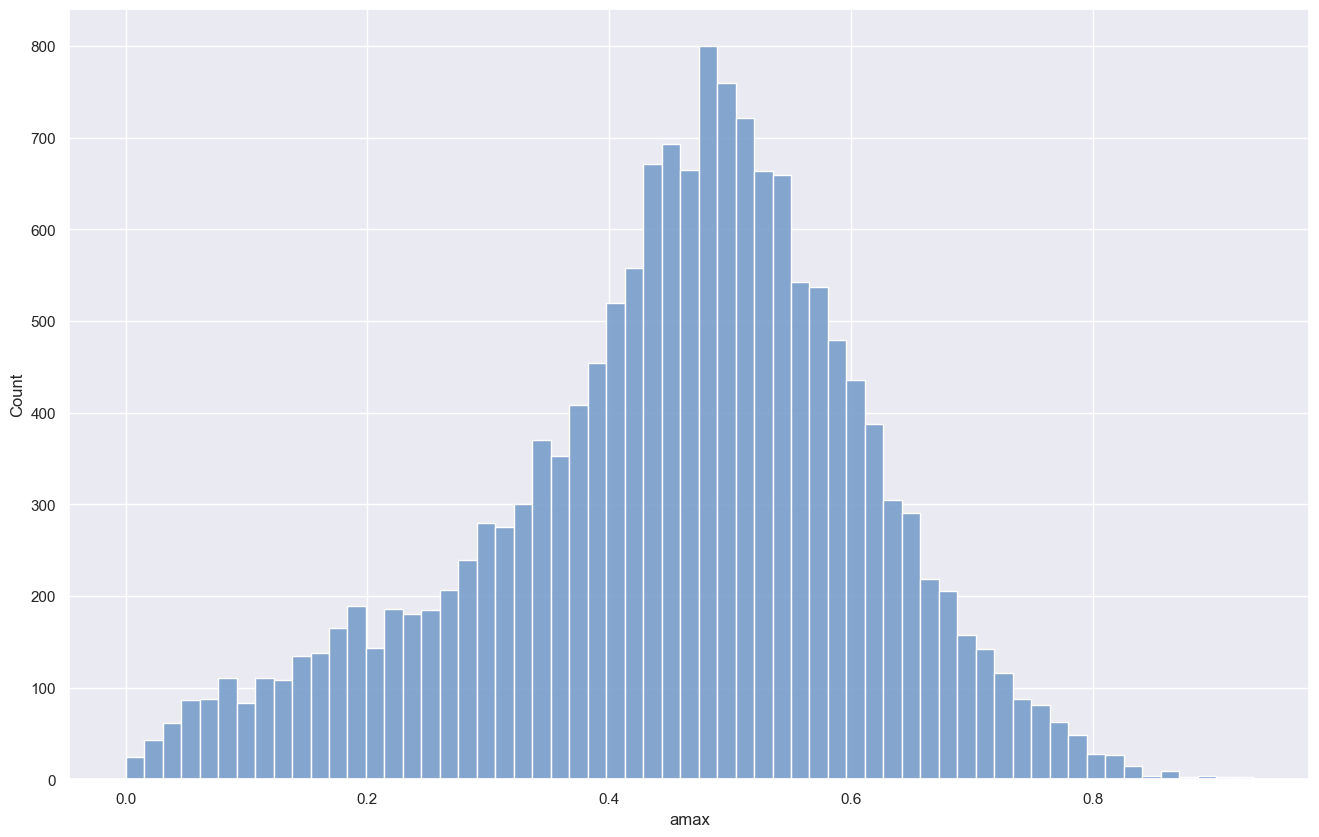

Function : numpy.std
Genes below 10th percentile [   0.013167] :  1,582
Genes below 30th percentile [   0.044166] :  4,746
Genes above 70th percentile [   0.088293] :  4,746
Genes above 90th percentile [   0.121443] :  1,582



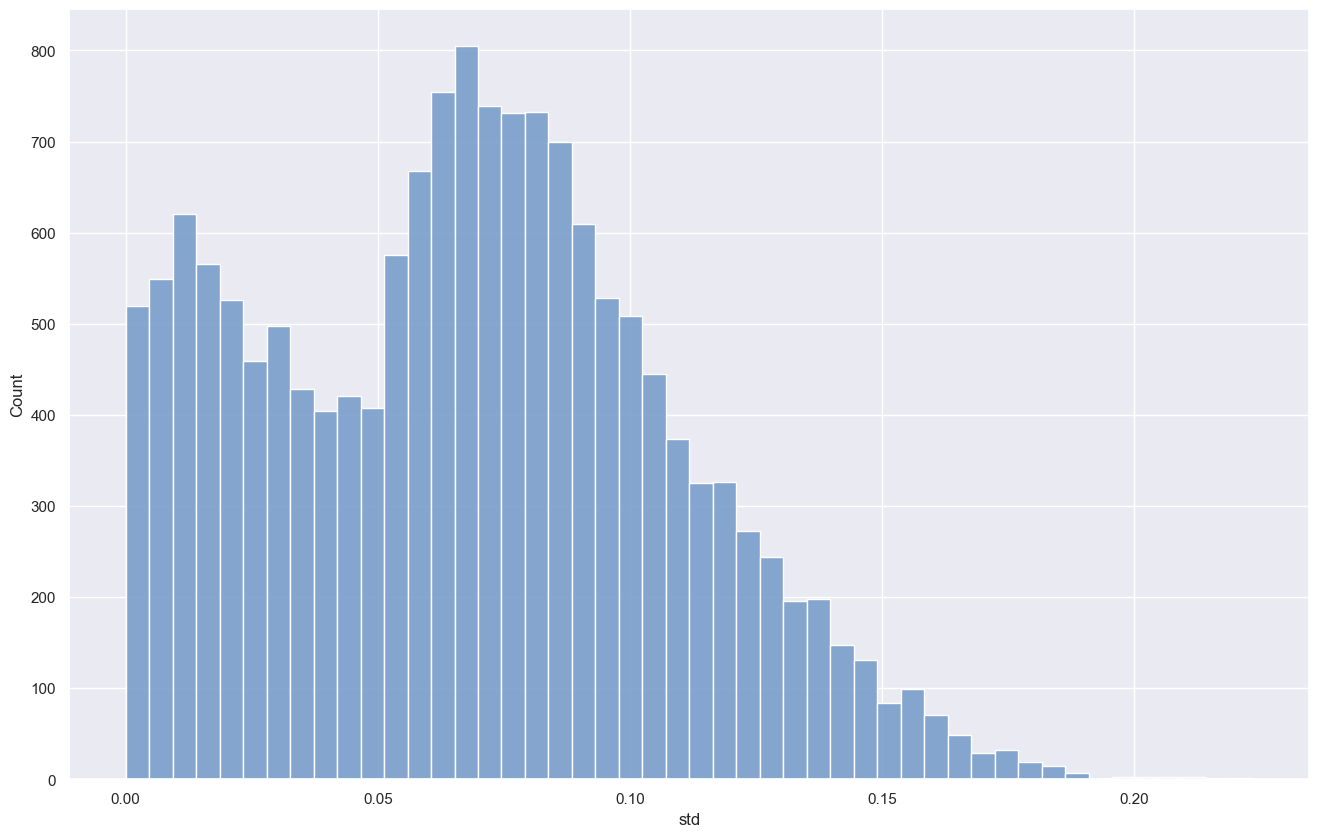

In [32]:
# Display boxcox1p tpm value distribution per gene

for name, function in functions :
	if name == 'min' : continue

	feature_anndata.tpm_histplot(
		data     = anndata[:, drop_transcript],
		layer    = 'normal',
		function = function,
		filters  = None,
		filename = os.path.join(OUT_PLOT, 'distribution-normal-drop-' + name)
	)

	matplotlib.pyplot.show()

## 5.2 Transcripts

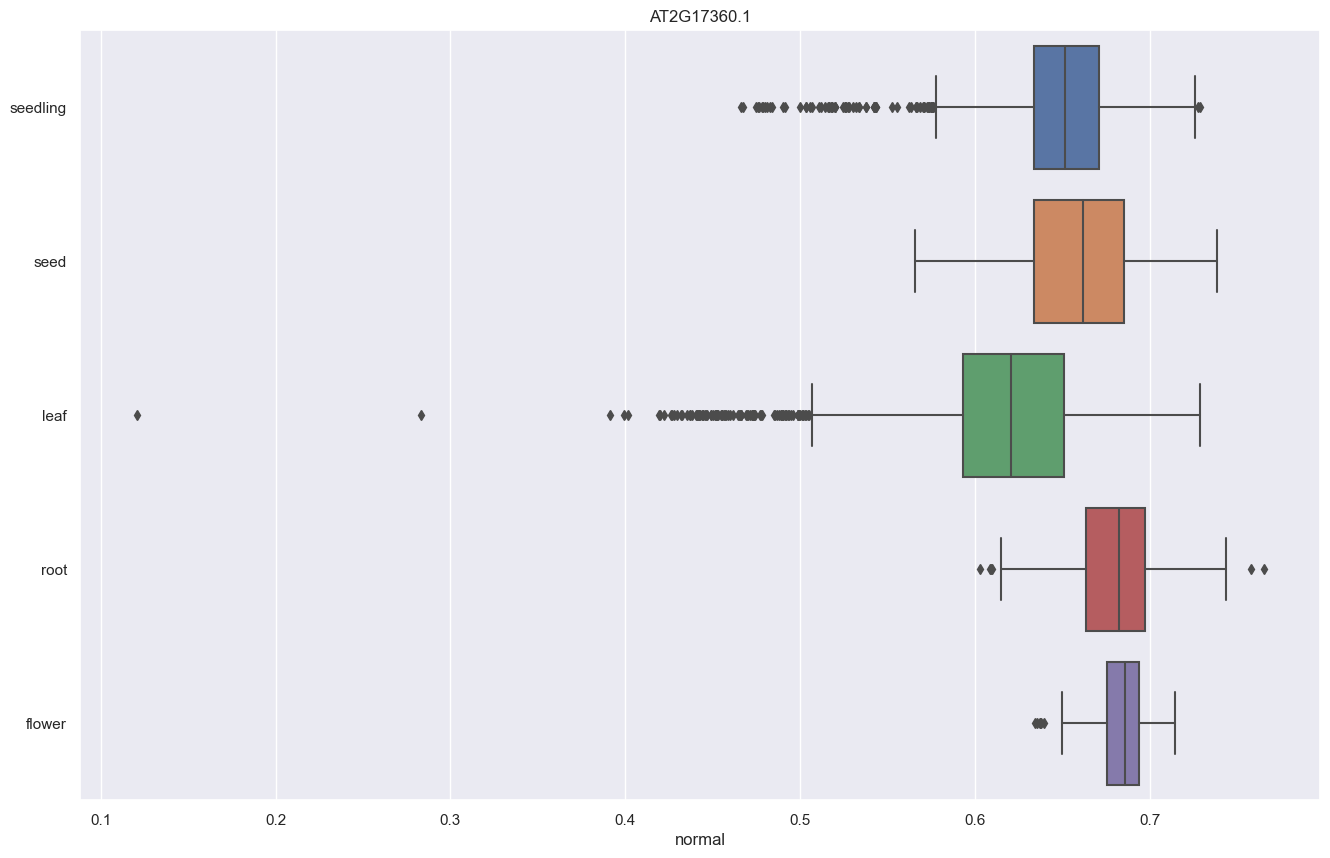

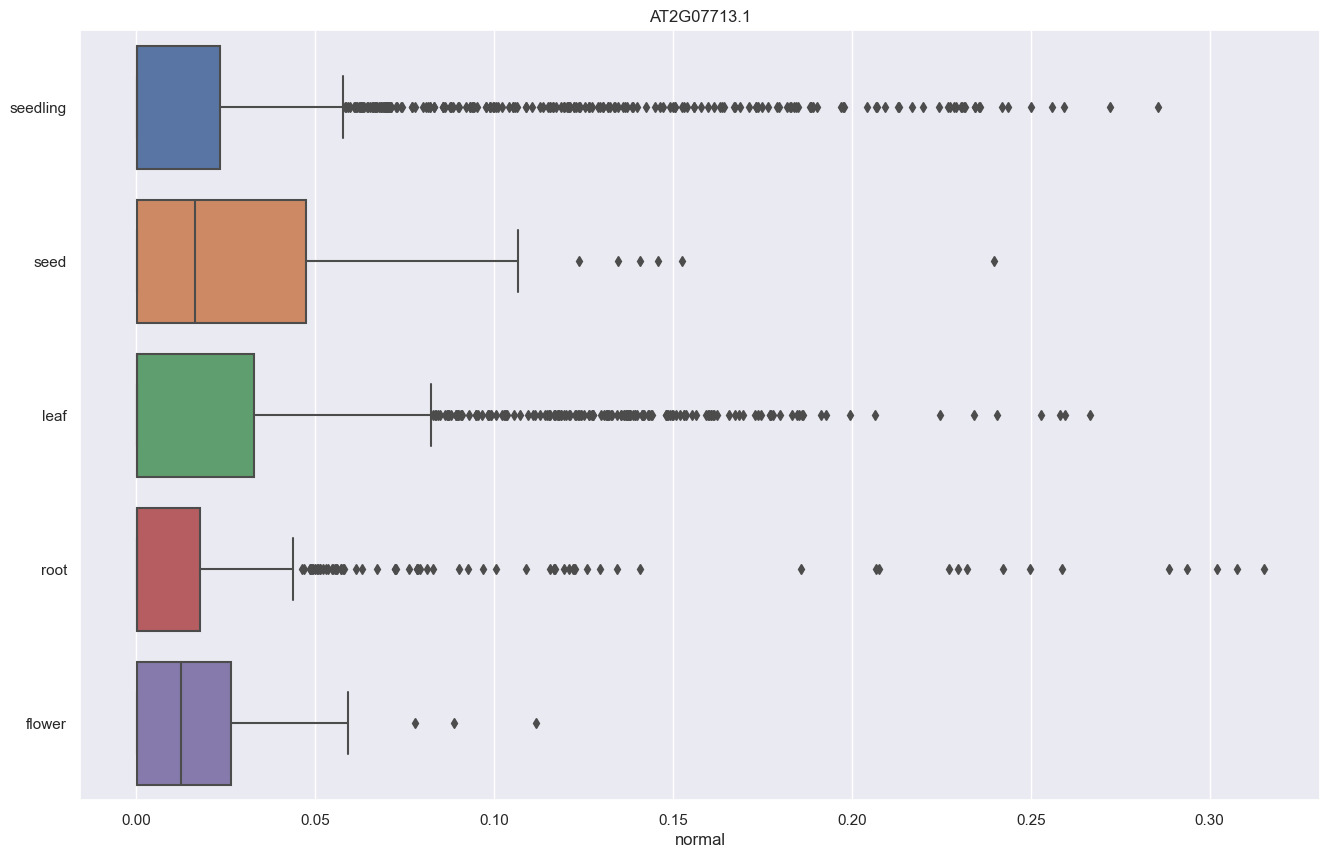

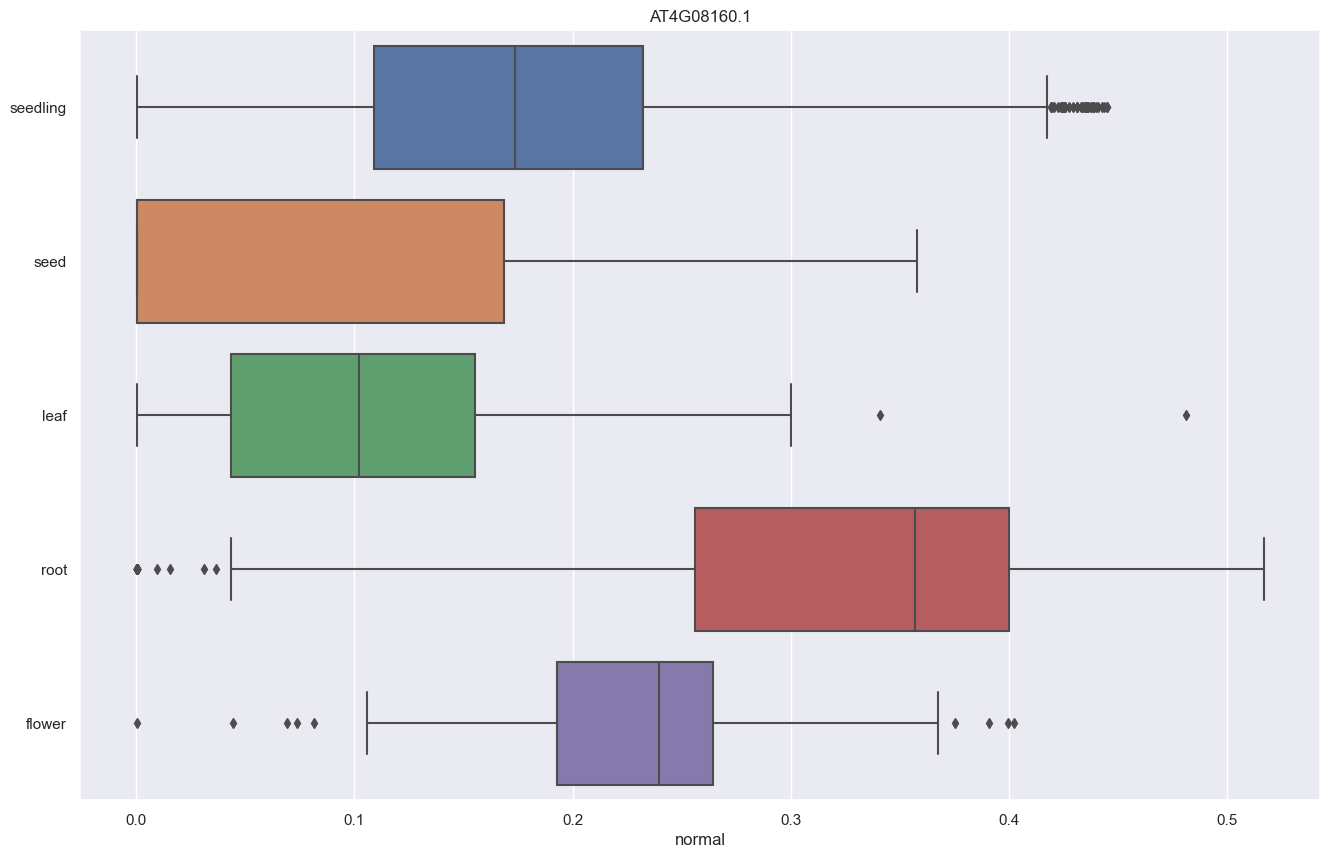

In [33]:
# Display an example of few transcript expressions per tissue

for transcript in boxplot_transcripts :
	if transcript not in anndata.var.index : continue

	feature_anndata.gene_boxplot(
		data       = anndata,
		transcript = transcript,
		groupby    = 'Tissue',
		layer      = 'normal',
		filename   = os.path.join(OUT_PLOT, 'tissue-normal-' + transcript)
	)

	matplotlib.pyplot.show()

# 6. Standard

In [34]:
# Compute and save the standardized tpm values

anndata, standard_factors = feature_anndata.compute_standardized(
	data       = anndata,
	layer      = mapping['standard'],
	store_into = 'standard',
	axis       = None
)

print('Mean : {}'.format(standard_factors['mean']))
print(' Std : {}'.format(standard_factors['std']))
print()

Mean : 1.401949568220438
 Std : 1.1957553712403661



In [35]:
# Display anndata standardized tpm matrix information

feature_anndata.show_matrix(anndata, layer = 'standard')

   Max value :   3.69642
  Mean value :   0.00000 ± 1.00000
Median value :  -0.00228
   Min value :  -1.17244

Total elements        : 111,791,340
Total elements < -1.0 :  32,638,270 [ 29.20 %]
Total elements < -0.5 :  44,065,130 [ 39.42 %]
Total elements < -0.3 :  48,492,733 [ 43.38 %]
Total elements < -0.0 :  55,957,661 [ 50.06 %]
Total elements =  0.0 :           0 [  0.00 %]
Total elements >  0.0 :  55,833,679 [ 49.94 %]
Total elements >  0.3 :  46,909,372 [ 41.96 %]
Total elements >  0.5 :  40,029,061 [ 35.81 %]
Total elements >  1.0 :  21,361,300 [ 19.11 %]
Total elements >  2.0 :   2,051,868 [  1.84 %]

[[  0.829   0.580  -0.674   0.397   1.700   0.791   0.377  -0.227   1.941   2.504]
 [  0.877   0.426  -0.445   0.462   1.721   0.691   0.119  -0.754   1.928   2.457]
 [  1.102   0.549  -0.756   0.612   1.766   0.502   0.310  -0.532   1.938   2.433]
 [  1.004   0.632  -0.766   0.515   1.777   0.751  -0.223   0.239   1.911   2.526]
 [  1.086   0.477  -0.445   0.123   1.827   0.624 

## 6.1 Distribution

Function : numpy.mean
Genes below 10th percentile [   0.314305] :  1,160
Genes below 30th percentile [   0.598538] :  3,480
Genes above 70th percentile [   1.076671] :  3,480
Genes above 90th percentile [   1.526338] :  1,160



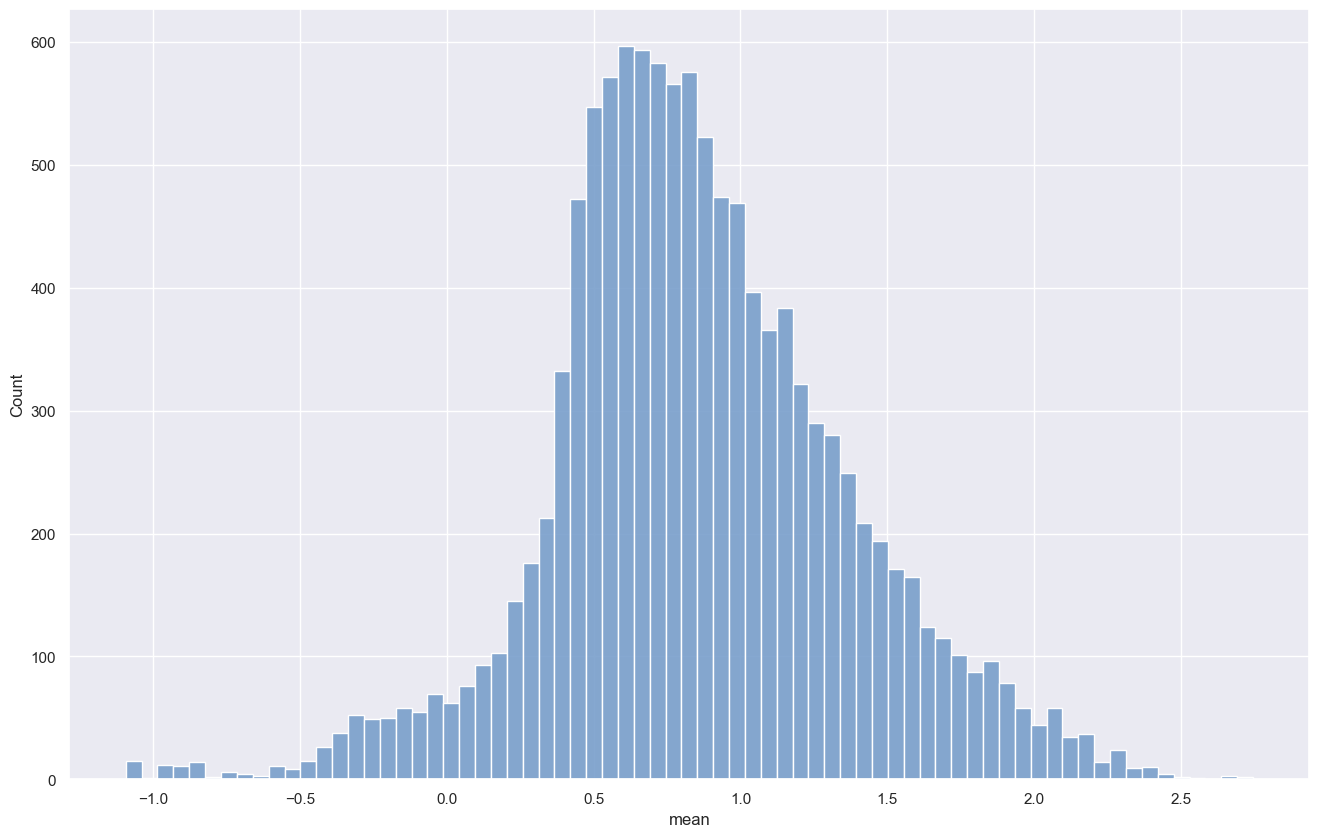

Function : numpy.amax
Genes below 10th percentile [   1.455010] :  1,160
Genes below 30th percentile [   1.729903] :  3,480
Genes above 70th percentile [   2.247934] :  3,480
Genes above 90th percentile [   2.652251] :  1,160



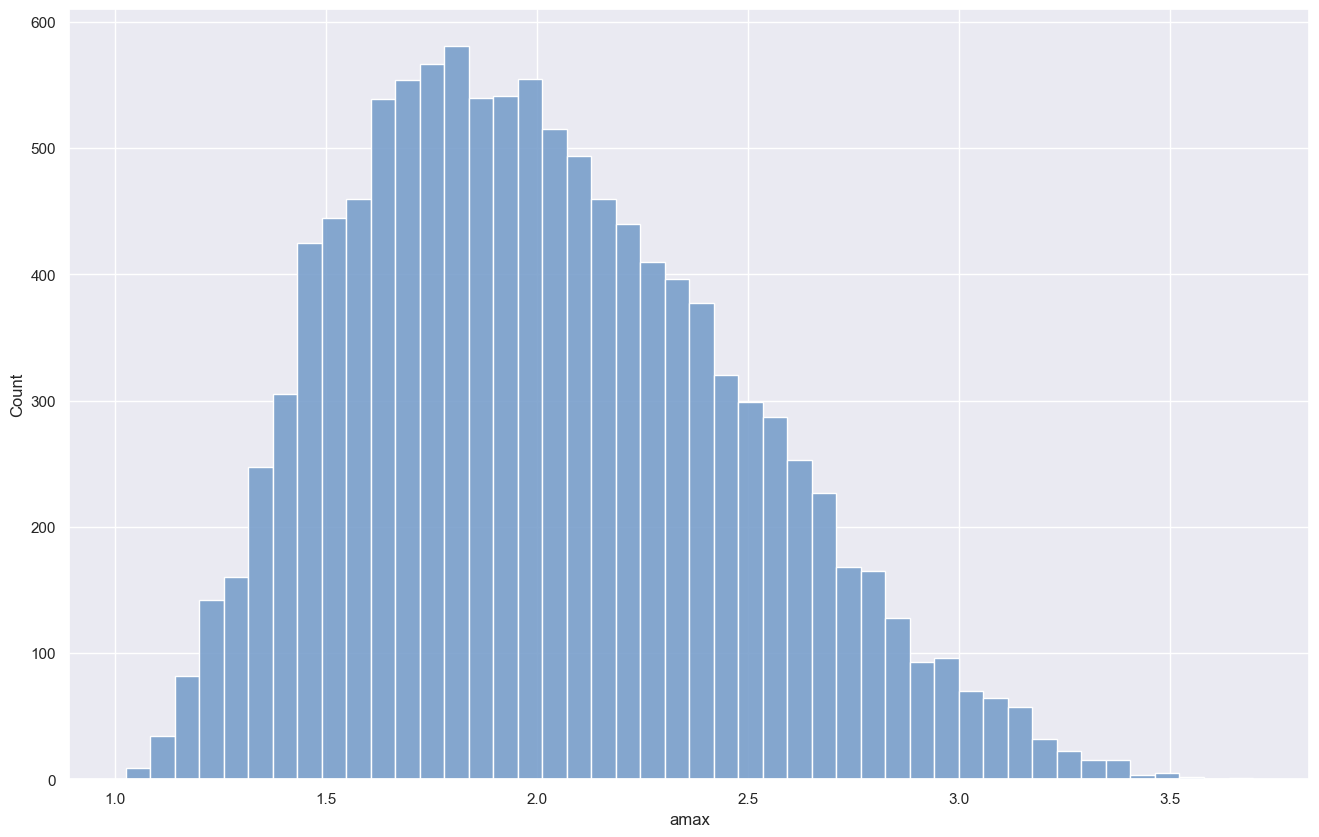

Function : numpy.std
Genes below 10th percentile [   0.273805] :  1,160
Genes below 30th percentile [   0.327343] :  3,480
Genes above 70th percentile [   0.525407] :  3,480
Genes above 90th percentile [   0.804925] :  1,160



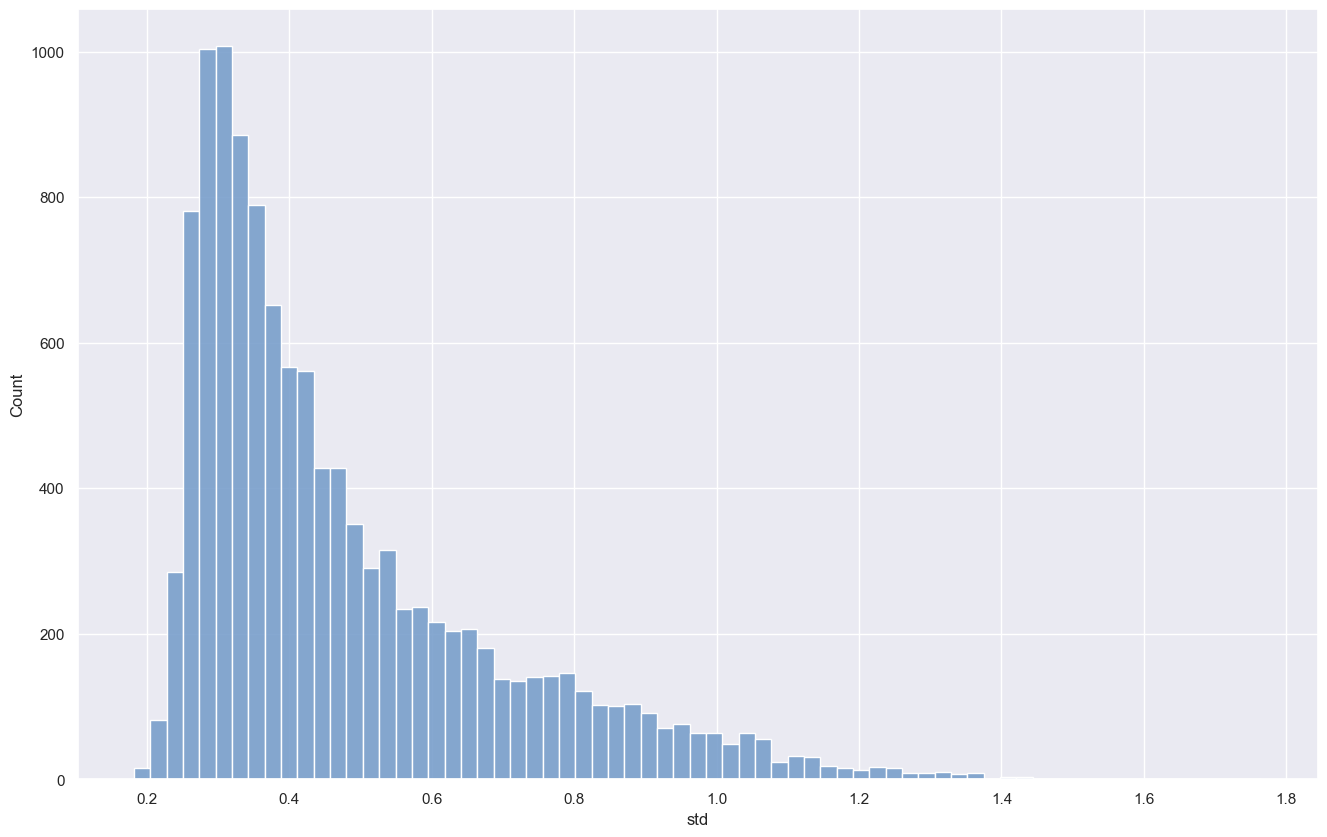

In [36]:
# Display normal tpm value distribution per gene

for name, function in functions :
	if name == 'min' : continue

	feature_anndata.tpm_histplot(
		data     = anndata[:, keep_transcript],
		layer    = 'standard',
		function = function,
		filters  = None,
		filename = os.path.join(OUT_PLOT, 'distribution-standard-keep-' + name)
	)

	matplotlib.pyplot.show()

Function : numpy.mean
Genes below 10th percentile [  -1.162178] :  1,582
Genes below 30th percentile [  -1.097941] :  4,746
Genes above 70th percentile [  -0.297113] :  4,746
Genes above 90th percentile [   0.168878] :  1,582



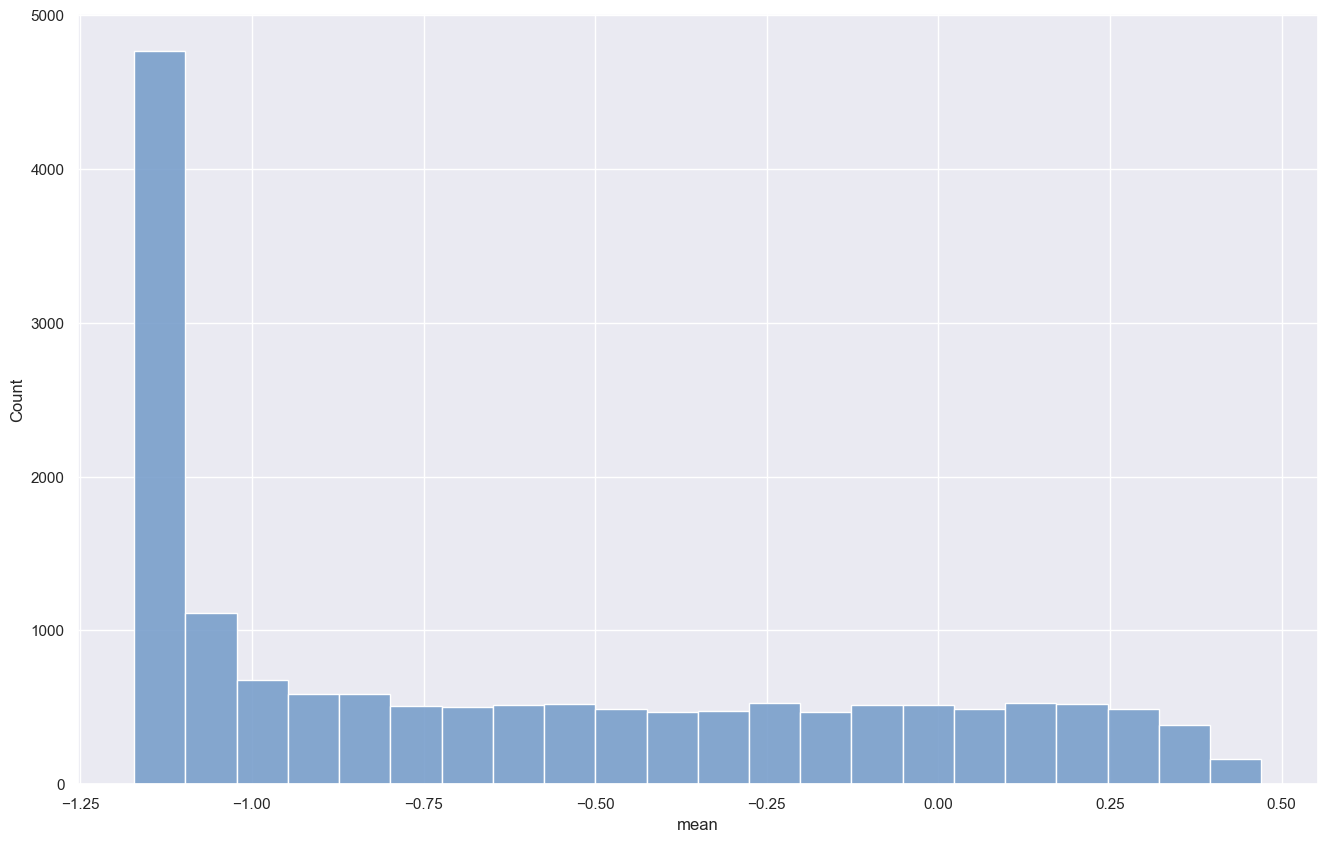

Function : numpy.amax
Genes below 10th percentile [  -0.091579] :  1,582
Genes below 30th percentile [   0.733012] :  4,746
Genes above 70th percentile [   1.444946] :  4,746
Genes above 90th percentile [   1.935511] :  1,582



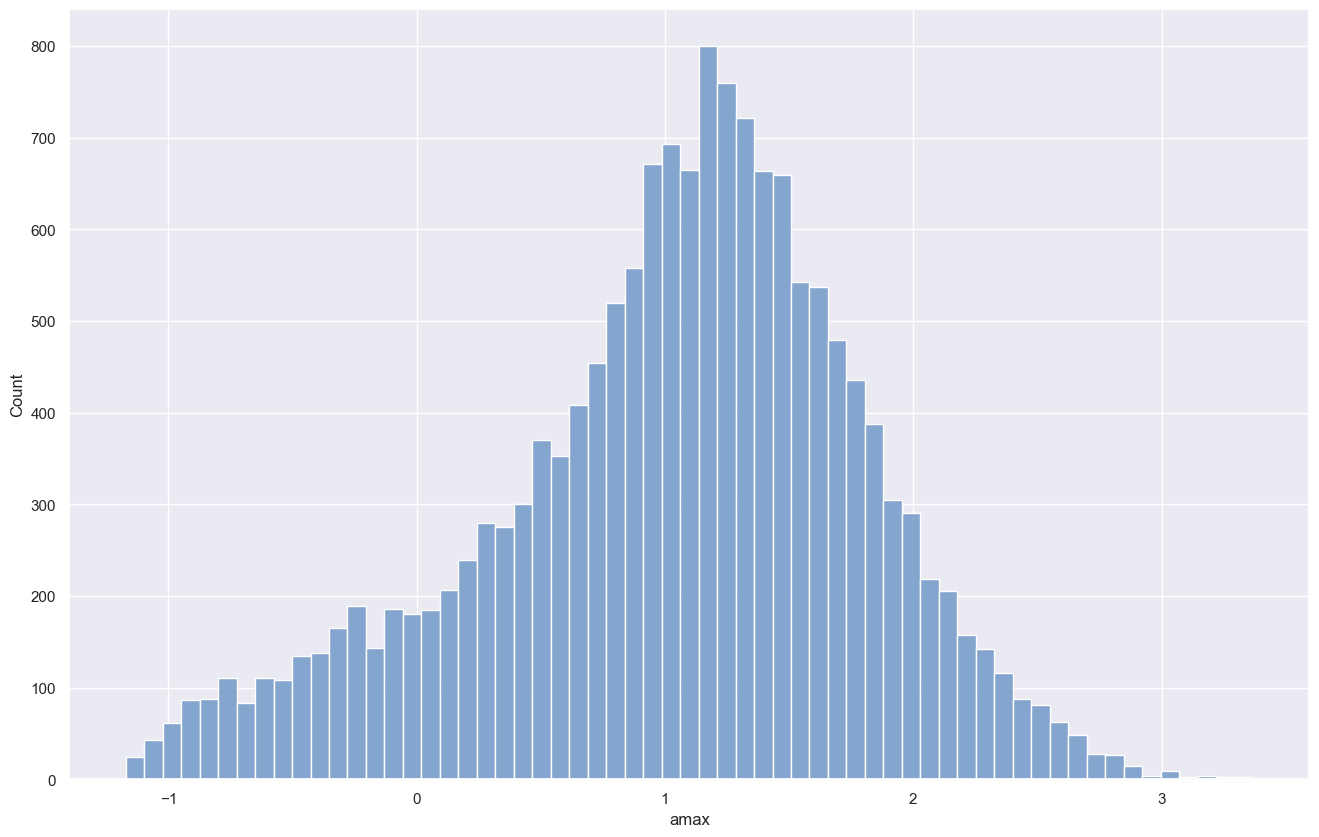

Function : numpy.std
Genes below 10th percentile [   0.064108] :  1,582
Genes below 30th percentile [   0.215036] :  4,746
Genes above 70th percentile [   0.429884] :  4,746
Genes above 90th percentile [   0.591289] :  1,582



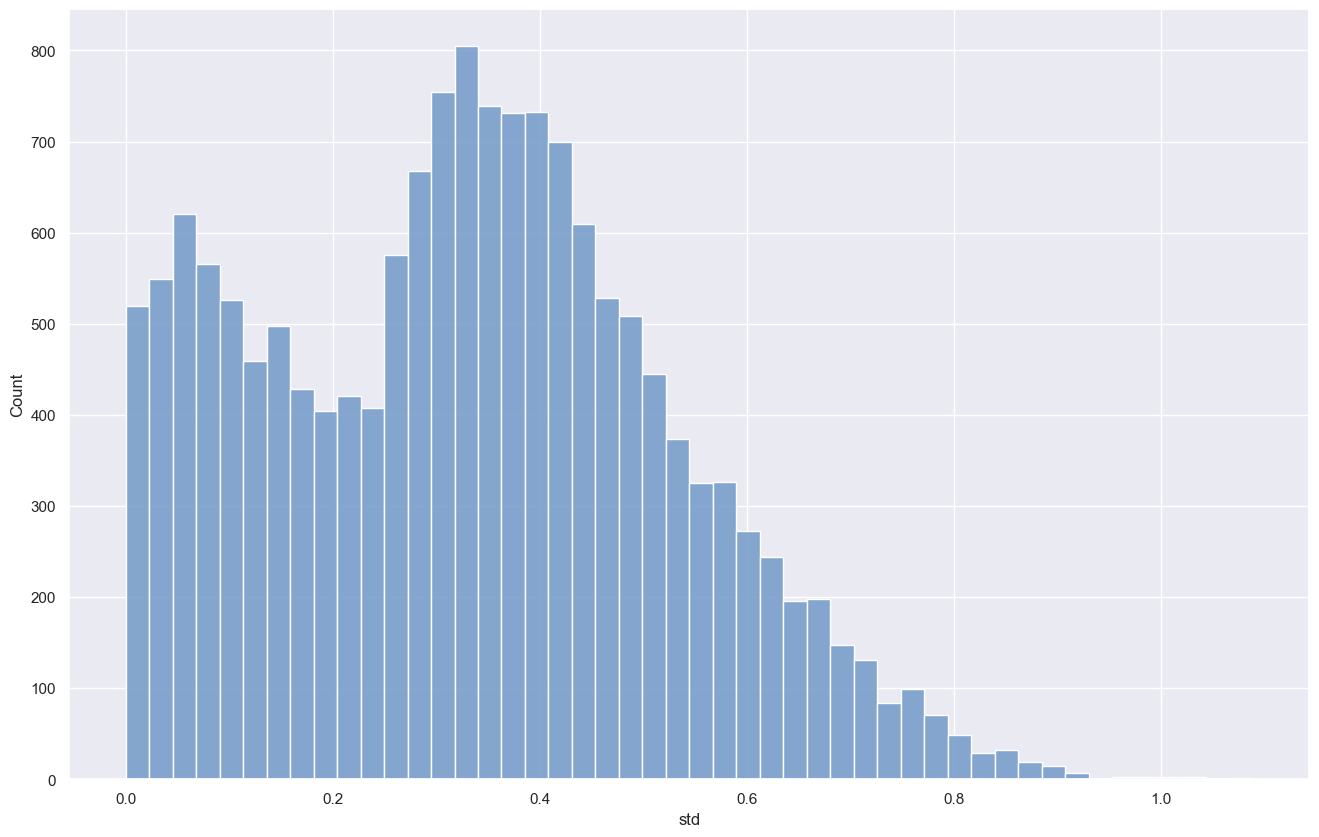

In [37]:
# Display normal tpm value distribution per gene

for name, function in functions :
	if name == 'min' : continue

	feature_anndata.tpm_histplot(
		data     = anndata[:, drop_transcript],
		layer    = 'standard',
		function = function,
		filters  = None,
		filename = os.path.join(OUT_PLOT, 'distribution-standard-drop-' + name)
	)

	matplotlib.pyplot.show()

## 6.2 Transcripts

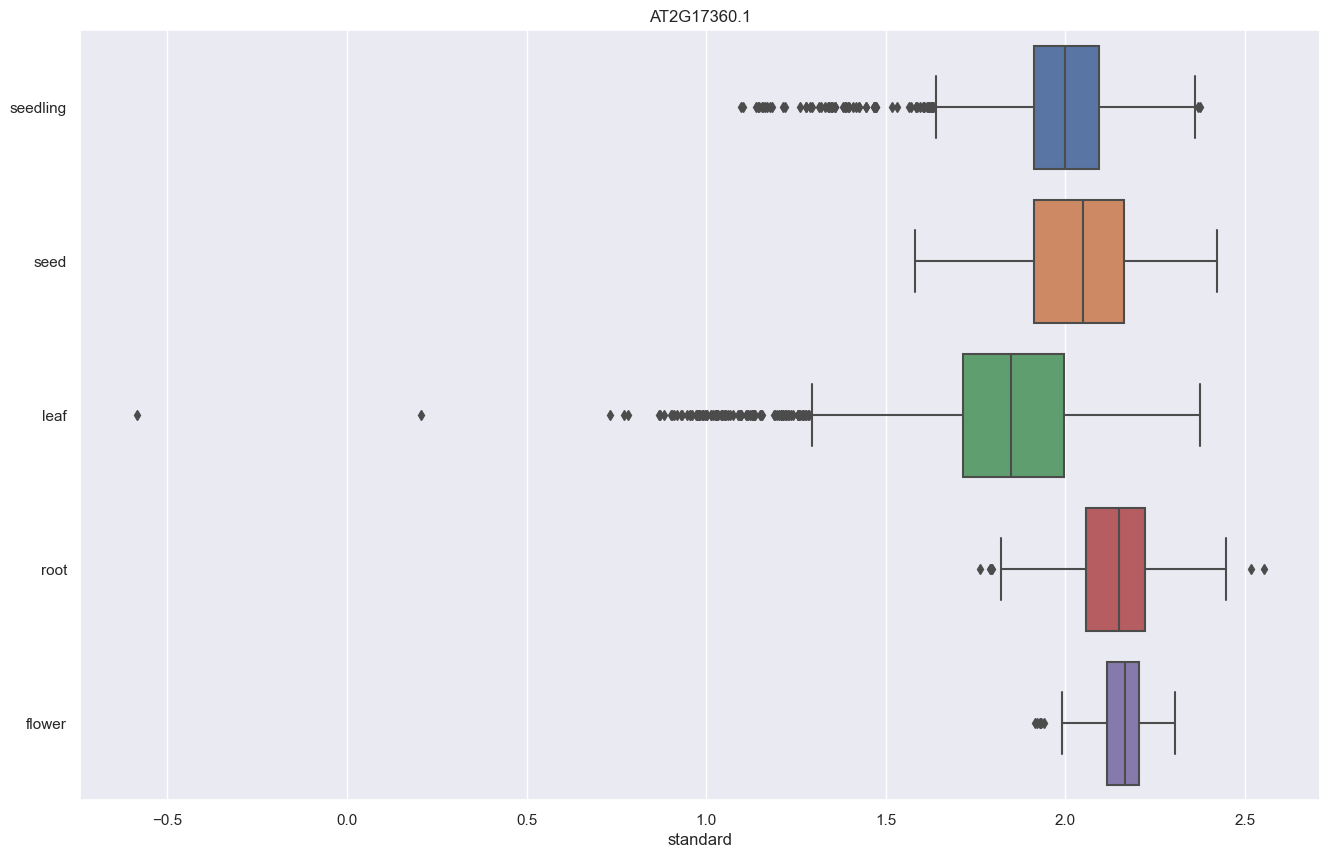

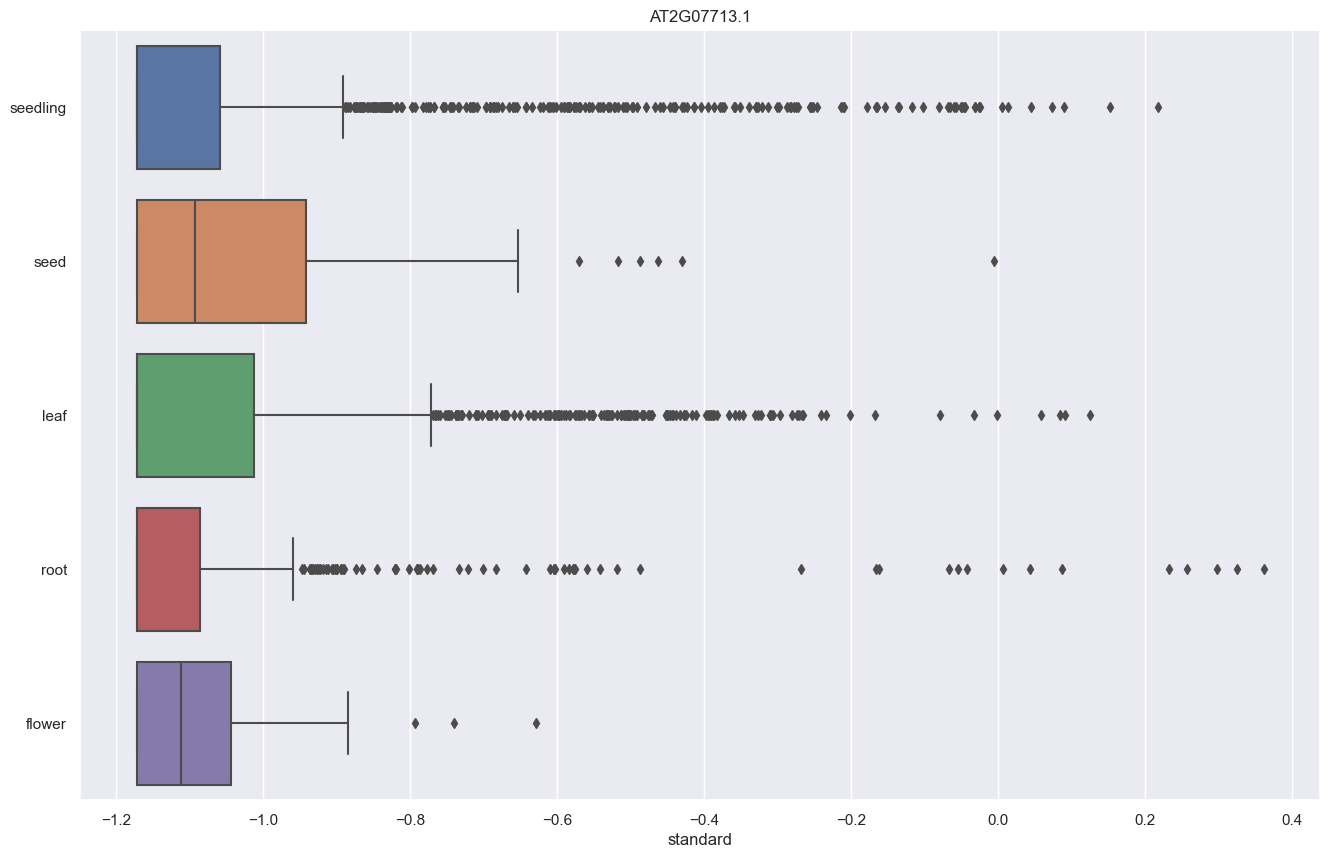

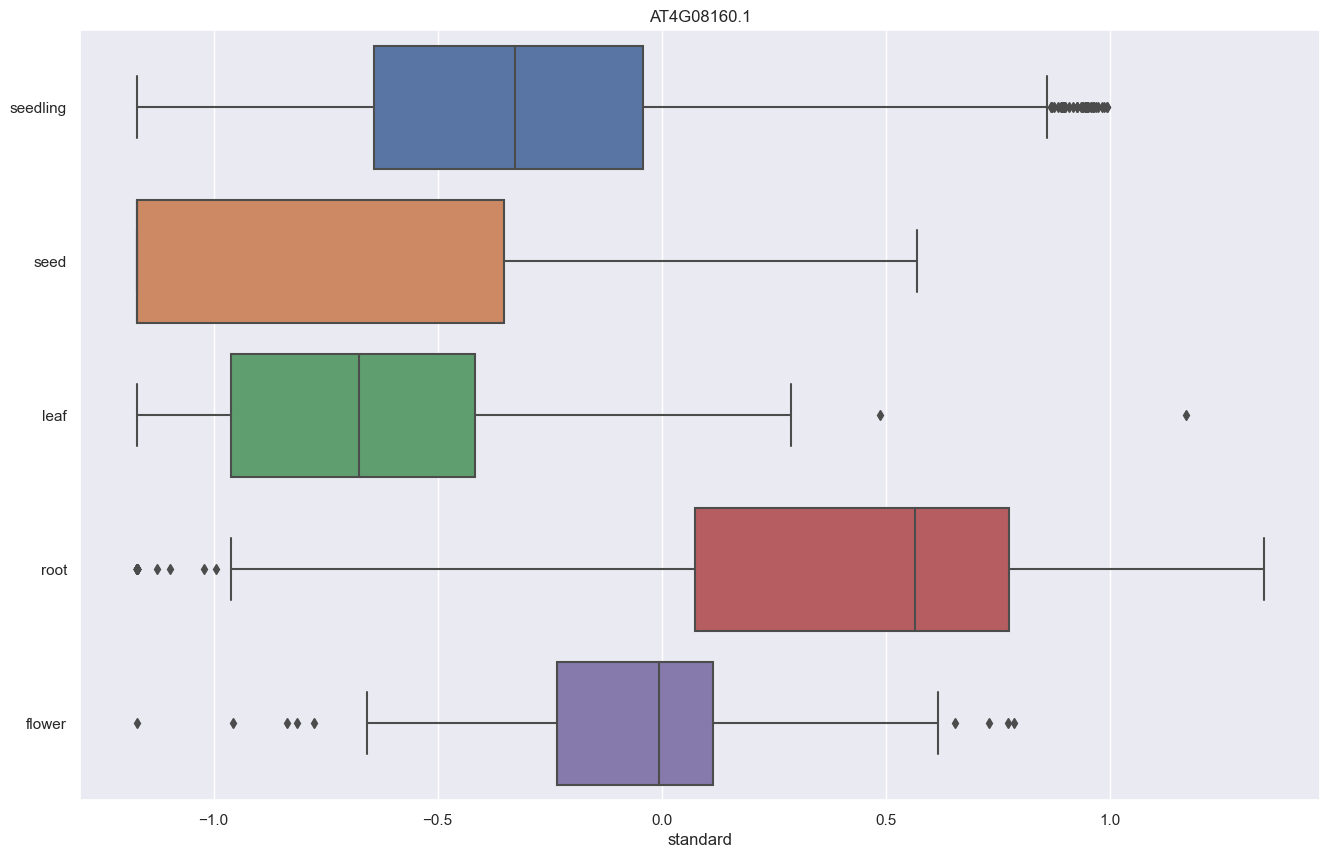

In [38]:
# Display an example of few transcript expressions per tissue

for transcript in boxplot_transcripts :
	if transcript not in anndata.var.index : continue

	feature_anndata.gene_boxplot(
		data       = anndata,
		transcript = transcript,
		groupby    = 'Tissue',
		layer      = 'standard',
		filename   = os.path.join(OUT_PLOT, 'tissue-standard-' + transcript)
	)

	matplotlib.pyplot.show()

# 7. Save

In [39]:
# Save the annotated data with multiple layers

writer.write_h5ad(
	data     = anndata,
	filename = os.path.join(OUT_DATA, 'arabidopsis-r36.h5ad')
)

In [40]:
# Save processing info

writer.write_json(
	data     = mapping,
	filename = os.path.join(OUT_DATA, 'layer-mapping.json')
)

writer.write_json(
	data     = boxcox_factors,
	filename = os.path.join(OUT_DATA, 'factors-boxcox.json')
)

writer.write_json(
	data     = normal_factors,
	filename = os.path.join(OUT_DATA, 'factors-normal.json')
)

writer.write_json(
	data     = standard_factors,
	filename = os.path.join(OUT_DATA, 'factors-standard.json')
)

writer.write_csv(
	data        = statistic_log1p_basic,
	filename    = os.path.join(OUT_DATA, 'statistics-log1p-basic.csv'),
	write_index = True
)

writer.write_csv(
	data        = statistic_log1p_advance,
	filename    = os.path.join(OUT_DATA, 'statistics-log1p-advance.csv'),
	write_index = True
)

writer.write_csv(
	data        = statistic_log1p_normality,
	filename    = os.path.join(OUT_DATA, 'statistics-log1p-normality.csv'),
	write_index = True
)

writer.write_csv(
	data        = statistic_boxcox1p_basic,
	filename    = os.path.join(OUT_DATA, 'statistics-boxcox1p-basic.csv'),
	write_index = True
)

writer.write_csv(
	data        = statistic_boxcox1p_advance,
	filename    = os.path.join(OUT_DATA, 'statistics-boxcox1p-advance.csv'),
	write_index = True
)

writer.write_csv(
	data        = statistic_boxcox1p_normality,
	filename    = os.path.join(OUT_DATA, 'statistics-boxcox1p-normality.csv'),
	write_index = True
)

# 8. Distributions

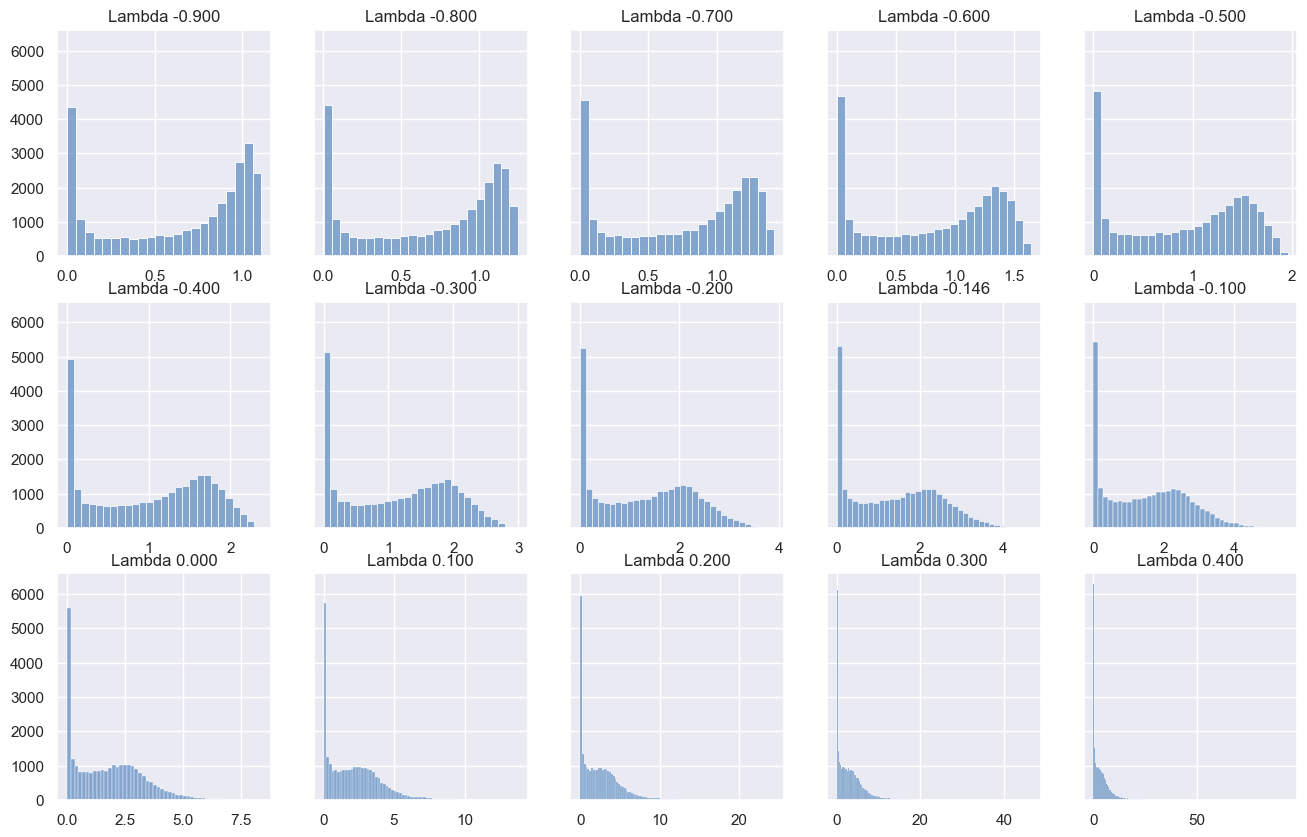

In [41]:
# Plot multiple lambda distributions to compare

LMBDA = boxcox_factors['lambda']
EPS   = boxcox_factors['eps']

lambdas = sorted([
	-0.9, -0.8, -0.7, -0.6, -0.5,
	-0.4, -0.3, -0.2, -0.1,  0.0,
	 0.1,  0.2,  0.3,  0.4, LMBDA
])

fig, ax = matplotlib.pyplot.subplots(
	nrows   = 3,
	ncols   = 5,
	figsize = (16, 10),
	sharex  = False,
	sharey  = True
)

for index, lmbda in enumerate(lambdas) :
	if lmbda is None :
		matrix = anndata.X
		title  = 'Original'
	else :
		layer = 'boxcox1p-{}'.format(index)

		anndata, _ = feature_anndata.compute_boxcox1p(
			data       = anndata,
			store_into = layer,
			layer      = None,
			eps        = EPS,
			lmbda      = lmbda
		)

		matrix = anndata.layers[layer]
		title  = 'Lambda {:.3f}'.format(lmbda)

	irow = index // 5
	icol = index  % 5

	data = pandas.DataFrame.from_dict({
		'Values' : numpy.mean(matrix, axis = 0)
	})

	seaborn.histplot(
		data  = data,
		x     = 'Values',
		alpha = 0.9,
		color = '#799FCB',
		ax    = ax[irow, icol],
		kde   = False
	)

	ax[irow, icol].set_title(title, loc = 'center')
	ax[irow, icol].set_ylabel(None)
	ax[irow, icol].set_xlabel(None)

matplotlib.pyplot.savefig(
	os.path.join(OUT_PLOT, 'distribution-lambda.png'),
	dpi    = 120,
	format = 'png'
)